<a href="https://colab.research.google.com/github/Hilco1/Movie-Recommendation-System/blob/main/Movie%20Recommendation%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project we are developing a movie recommendation system using the MovieLens dataset. The goal is to build a model that suggests the top 5 movies for a user based on their past ratings. We also tackle the cold start problem by enabling the system to make recommendations for users who haven't rated any movies yet.

In [ ]:
!pip install --upgrade numpy==1.23.5
!pip install scikit-surprise --no-binary :all:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

from surprise import Reader, Dataset, dump
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNBasic, KNNBaseline, SVD, SVDpp
from surprise.accuracy import rmse

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
import nltk
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
%matplotlib inline


  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469536 sha256=52a9070417f3664ddeeaf36cdf46458b4ce3c93ebdbbafea64809529b09f3a36
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
55
from google.colab import files
uploaded = files.upload()


In [ ]:
# Import datasets
df_movies = pd.read_csv('/content/movies (2).csv')
df_ratings = pd.read_csv('/content/ratings (2).csv')

In [ ]:
# Show first rows
display(df_movies.head())
display(df_ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Check for nulls and data types
display(df_movies.info())
display(df_ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

Exploring the movies dataset to gain a better understanding of its structure and contents.

In [ ]:
# Create column with array of genres and calculate the Number of Genres per movie
df_movies['genres_array'] = df_movies['genres'].str.split('|')

# Flattened genres
stacked_genres = df_movies['genres_array'].apply(pd.Series).stack(level=0).reset_index()
stacked_genres.columns = ['index', 'level_1', 'genre']

# Combine original dataframe with flattened genres using the index
df_movies_new = pd.merge(df_movies, stacked_genres, how='left', left_index=True, right_on=['index'])
df_movies_new = df_movies_new[['movieId', 'title', 'genre']]

In [ ]:
# One-hot Encoding of Genre column
one_hot = pd.get_dummies(df_movies_new['genre'])

# Get list of genres (it's going to be useful soon)
list_of_genres = list(one_hot.columns)

# Combine the new dataframe with the one-hot encoded dataframe
df_movies_new = pd.merge(df_movies_new, one_hot, left_index=True, right_index=True)
df_movies_new = df_movies_new.drop('genre', axis=1)

# Use groupby to have one row per movie
df_movies_new = df_movies_new.groupby(['movieId', 'title']).sum()[list_of_genres].reset_index()

In [ ]:
# Split year and title
df_movies_new['release_year'] = df_movies_new.apply(lambda x: x['title'].strip()[-5:][:-1], axis=1)
df_movies_new['release_year'] = df_movies_new.apply(lambda x:
                                                    x['release_year']
                                                    if len(re.findall("[0-9]{4}", x['release_year'])) == 1
                                                    else np.nan, axis=1)
df_movies_new['title'] = df_movies_new.apply(lambda x:
                                             x['title'][:-6].strip()
                                             if x['release_year'] != np.nan
                                             else x['title'], axis=1)

### Number of Movies by genre <a class="anchor" id="mg"></a>


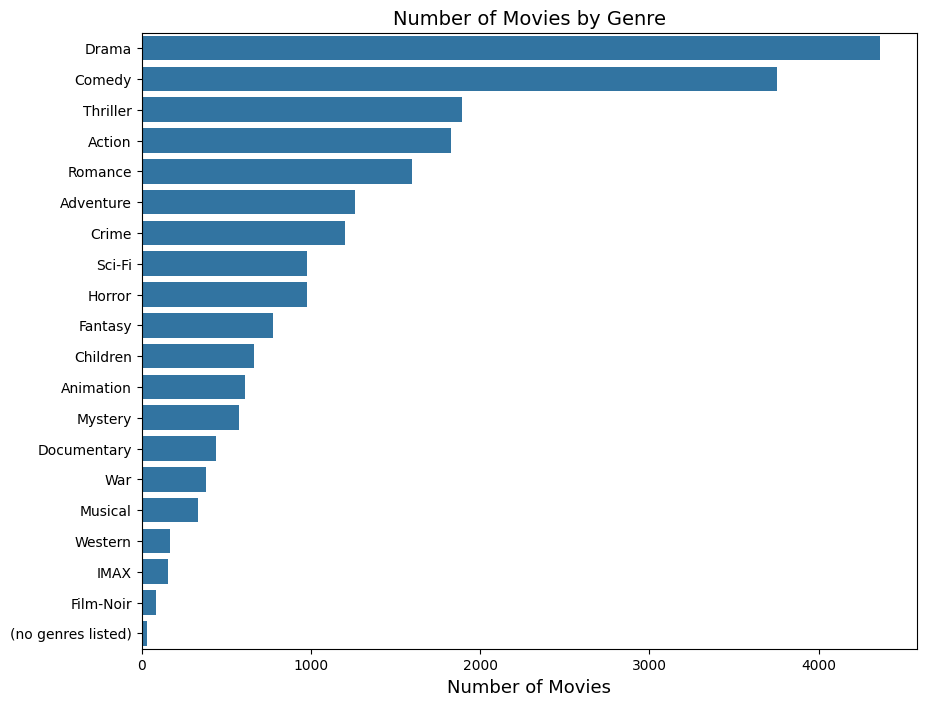

In [ ]:
# Create empty dictionary to store the no of movies by genre
no_of_movies_by_genre = {}

for genre in list_of_genres:
    no_of_movies = df_movies_new[genre].sum()
    no_of_movies_by_genre[genre] = no_of_movies

# Transform that into a dataframe
to_plot = pd.DataFrame.from_dict(no_of_movies_by_genre, orient='index').reset_index()
to_plot.columns = ['genre', 'no_of_movies']
to_plot = to_plot.sort_values('no_of_movies', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x="no_of_movies", y="genre", data=to_plot)
plt.title('Number of Movies by Genre', size=14)
plt.xlabel('Number of Movies', size=13)
plt.ylabel(None)
plt.show()


The dataset is imbalanced in terms of movie genres, with Drama and Comedy being significantly more represented than others. As a result, the model will have fewer options to choose from when recommending movies in less common genres

### Number of Ratings by Genre

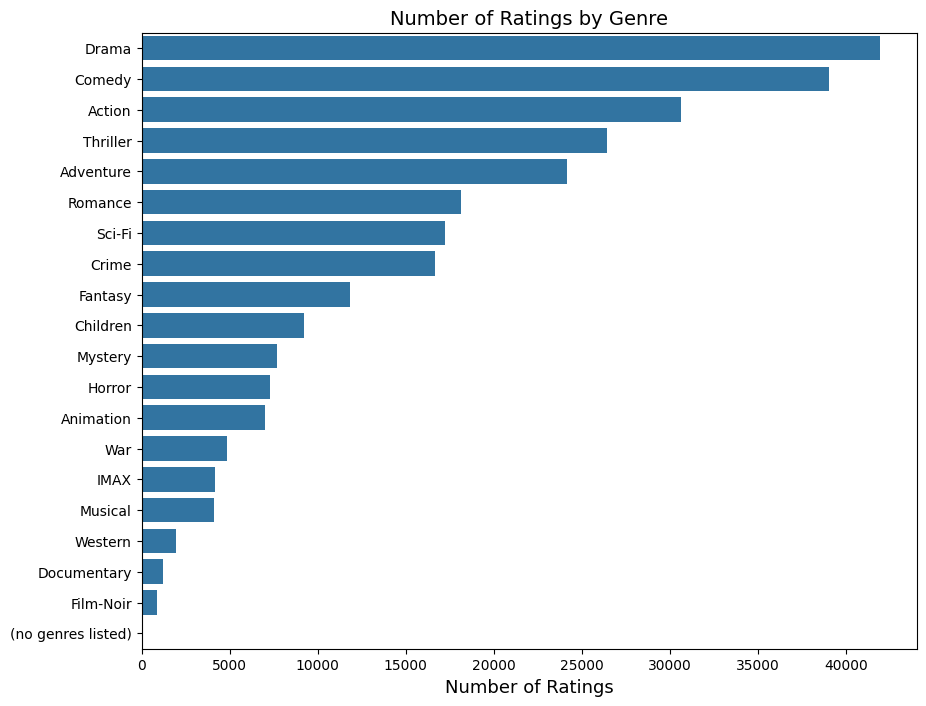

In [ ]:
# Combine movies with stacked genres and add ratings
df_movies_stacked = pd.merge(df_movies, stacked_genres, how='left', left_index=True, right_on=['index'])
to_plot = pd.merge(df_movies_stacked, df_ratings, on='movieId')
to_plot = to_plot.groupby('genre').count()['movieId'].reset_index()
to_plot.columns = ['genre', 'no_of_ratings']
to_plot = to_plot.sort_values('no_of_ratings', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x="no_of_ratings", y="genre", data=to_plot)
plt.title('Number of Ratings by Genre', size=14)
plt.xlabel('Number of Ratings', size=13)
plt.ylabel(None)
plt.show()


The distribution remains consistent with previous observations. However, there's a straightforward way to directly compare the two sets of numbers

### Average Number of Ratings by Movies and Genre

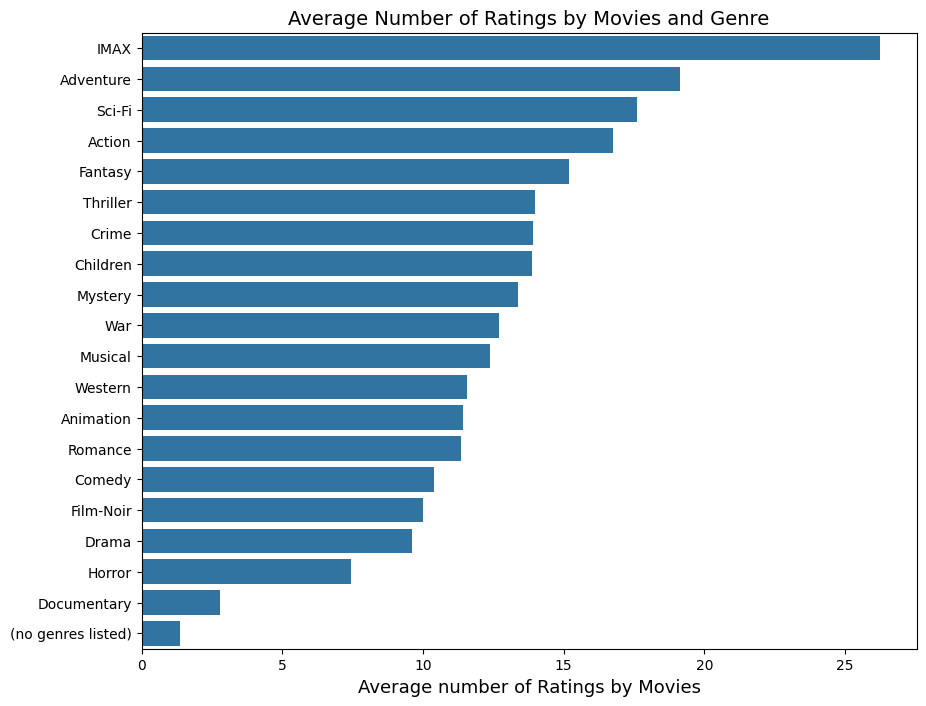

In [ ]:
no_of_movies_by_genre = df_movies_stacked.groupby('genre').count()['movieId'].reset_index()
ratings_genres_movies = pd.merge(df_movies_stacked, df_ratings, on='movieId')
no_of_ratings_by_genre = ratings_genres_movies.groupby('genre').count()['rating']
combined_df = pd.merge(no_of_movies_by_genre, no_of_ratings_by_genre, on='genre')
combined_df.columns = ['genre', 'number_of_movies', 'number_of_ratings']
combined_df['number_of_ratings_by_movie'] = combined_df['number_of_ratings'] / combined_df['number_of_movies']
combined_df = combined_df.sort_values('number_of_ratings_by_movie', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x="number_of_ratings_by_movie", y="genre", data=combined_df)
plt.title('Average Number of Ratings by Movies and Genre', size=14)
plt.xlabel('Average number of Ratings by Movies', size=13)
plt.ylabel(None)
plt.show()

The distribution here differs from what we saw earlier. On average, IMAX, Adventure, and Sci-Fi movies receive more ratings than other genres.

In [ ]:
# Combine movies with stacked genres and add ratings
df_movies_stacked_ratings = pd.merge(df_movies_stacked, df_ratings, on='movieId')
genres_to_analyze = ['IMAX', 'Adventure', 'Sci-Fi']
filtered_df = df_movies_stacked_ratings[df_movies_stacked_ratings['genre'].isin(genres_to_analyze)]
filtered_df = filtered_df.groupby(['title', 'genre']).count()['movieId'].sort_values(ascending=False)\
                                                                        .reset_index()
filtered_df[['title', 'movieId']].drop_duplicates().head(15)


,title,movieId
0,"Matrix, The (1999)",278
1,Star Wars: Episode IV - A New Hope (1977),251
3,Jurassic Park (1993),238
5,Terminator 2: Judgment Day (1991),224
6,Toy Story (1995),215
7,Star Wars: Episode V - The Empire Strikes Back...,211
9,Independence Day (a.k.a. ID4) (1996),202
11,Apollo 13 (1995),201
13,Raiders of the Lost Ark (Indiana Jones and the...,200
14,"Lord of the Rings: The Fellowship of the Ring,...",198



We can see that there are several sequels with large fanbases, such as Star Wars, Terminator, and The Lord of the Rings. We also see major blockbusters like The Matrix and Jurassic Park represented.

### Ratings Distribution by Genre

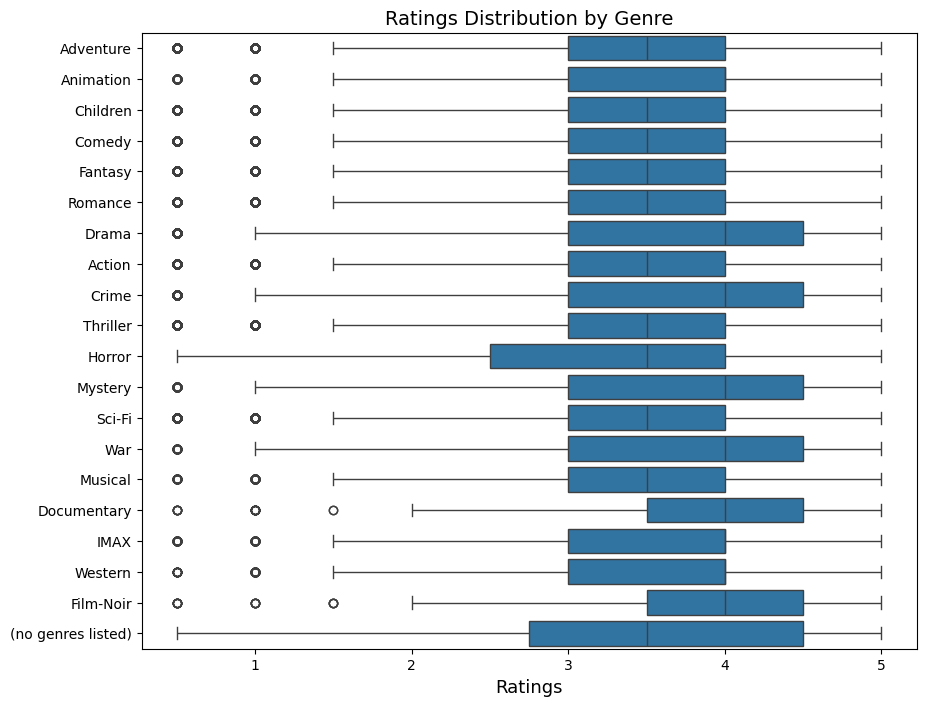

In [ ]:
# Combine movies with stacked genres and add ratings
df_movies_stacked = pd.merge(df_movies, stacked_genres, how='left', left_index=True, right_on=['index'])
to_plot = pd.merge(df_movies_stacked, df_ratings, on='movieId')

# Plot
plt.figure(figsize=(10,8))
sns.boxplot(x='rating', y='genre', data=to_plot)

# Title and Label
plt.title('Ratings Distribution by Genre', size=14)
plt.xlabel('Ratings', size=13)
plt.ylabel(None)
plt.show();




### Number of Ratings per Year <a class="anchor" id="ry"></a>




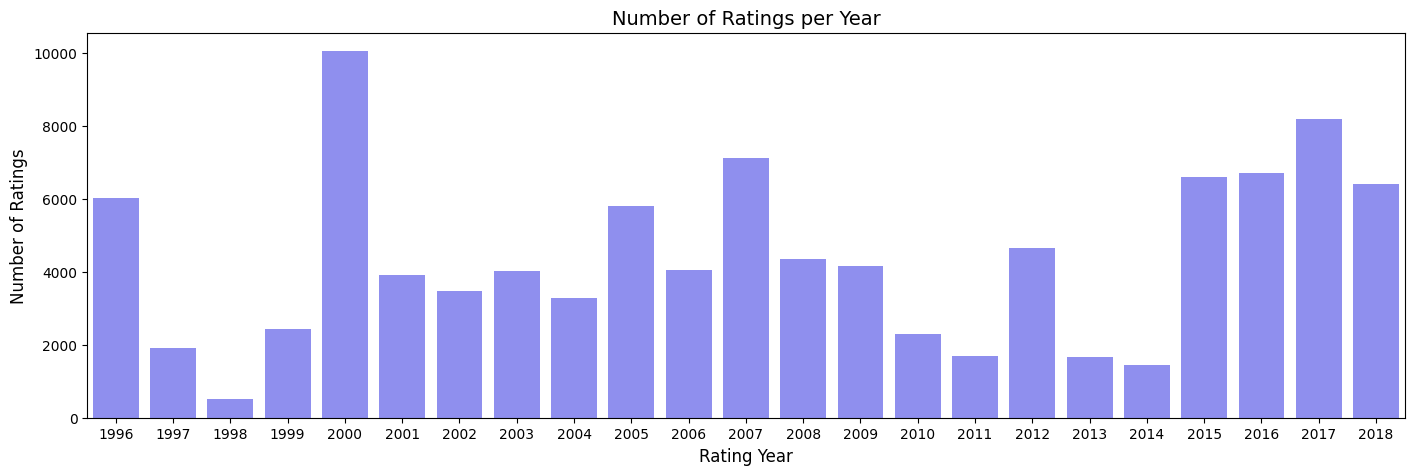

In [ ]:
# Convert timestamp column to datetime
df_ratings['datetime'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings['year'] = df_ratings['datetime'].dt.year

# Create plot with Number of ratings per year
to_plot = df_ratings.groupby('year').count()['rating'].reset_index()
plt.figure(figsize=(17,5))
sns.barplot(x='year', y='rating', data=to_plot, color='blue', alpha=0.5)

# Set title and labels
plt.title('Number of Ratings per Year', size=14)
plt.xlabel('Rating Year', size=12)
plt.ylabel('Number of Ratings', size=12)
plt.show()

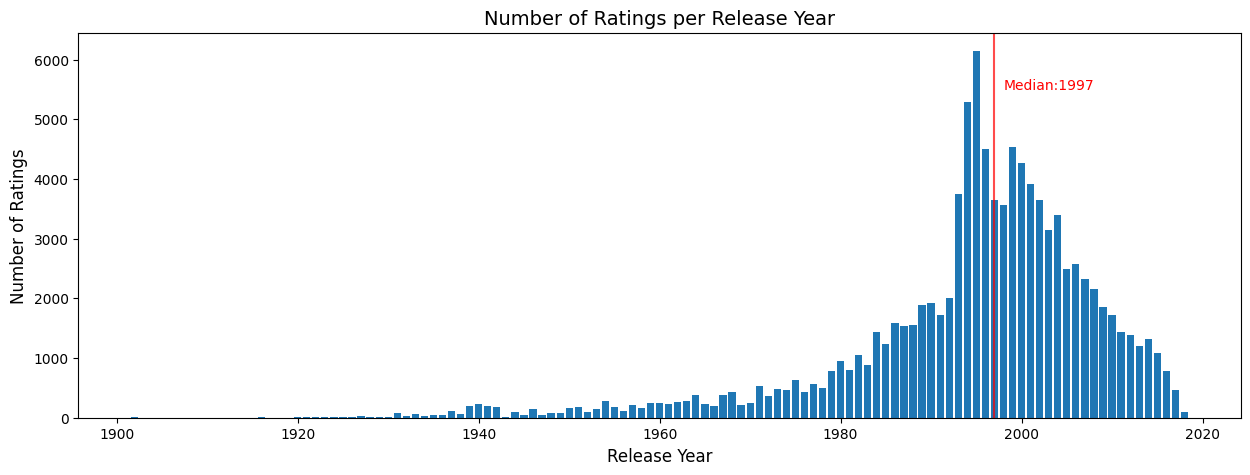

In [ ]:
# Create plot with Number of Ratings per Release Year
to_plot = pd.merge(df_ratings, df_movies_new[['movieId', 'release_year']], on='movieId')
to_plot['release_year'] = pd.to_numeric(to_plot['release_year'])

# Calculate Median
median = to_plot['release_year'].median()

to_plot = to_plot.groupby('release_year').count()['movieId'].reset_index()

# Create plot
plt.figure(figsize=(15,5))
plt.bar(x=to_plot['release_year'],
        height=to_plot['movieId'])

# Add vertical line showing the median year
plt.axvline(x=median, color='red', alpha=0.7)
plt.text(median+1, 5500, f'Median:{int(median)}', color='red')

# Set title and labels
plt.title('Number of Ratings per Release Year', size=14)
plt.xlabel('Release Year', size=12)
plt.ylabel('Number of Ratings', size=12)
plt.show()

A significant portion of the ratings are concentrated around movies released in 1997.

### Number of Ratings by Rating Year and Movie Release Year <a class="anchor" id="rrymry"></a>


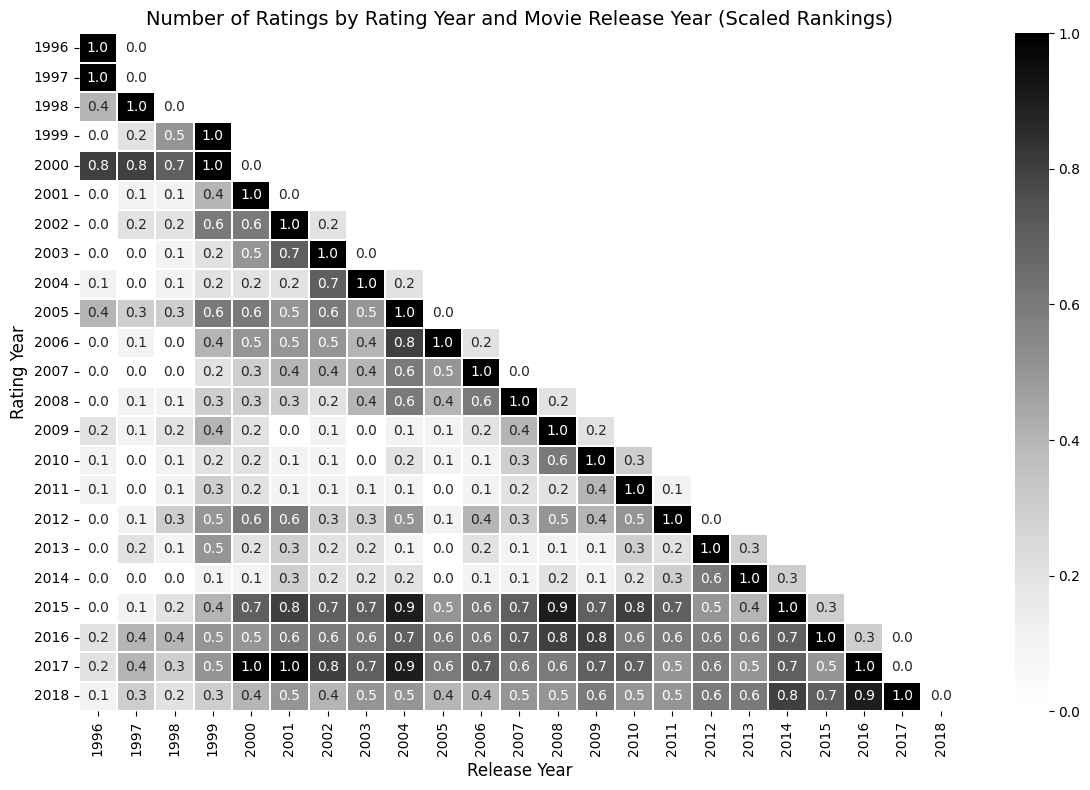

In [ ]:
# Instead of adding colors by the absolute number of ratings, we are going to rank them by scaling the number
# of votes per year. With that, it's going to be possible to see which Release years have the most number
# of ratings.

# Merge ratings with movie release year
to_plot = pd.merge(df_ratings, df_movies_new[['movieId', 'release_year']], on='movieId')

# Filter only records where release_year >= rating year minimum
min_year = to_plot['year'].min()
to_plot = to_plot[pd.to_numeric(to_plot['release_year'], errors='coerce') >= min_year]

# Count number of ratings grouped by rating year and release year
to_plot = to_plot.groupby(['year', 'release_year']).count()['userId'].reset_index()

# Rank the counts per rating year (normalize between 0 and 1)
to_plot['rank'] = to_plot.groupby('year')['userId'].transform(
    lambda x: round((x - x.min()) / (x.max() - x.min() + 1e-6), 1)
)

# Pivot for heatmap
to_plot_pivot = to_plot.pivot(index='year', columns='release_year', values='rank')

# Create the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(to_plot_pivot,
                 annot=True,
                 linewidths=.01,
                 cmap="Greys",
                 fmt='.1f')

# Set title and axis labels
plt.title('Number of Ratings by Rating Year and Movie Release Year (Scaled Rankings)', size=14)
ax.set_ylabel('Rating Year', size=12)
ax.set_xlabel('Release Year', size=12)

# Display the plot
plt.tight_layout()
plt.show()


It’s noticeable that users tend to rate movies released in the same year they submit their ratings.

However, starting around 2015, there’s a shift in behavior, with users increasingly rating older movies from previous years.

### Number of Users rating movies per Year <a class="anchor" id="urm"></a>


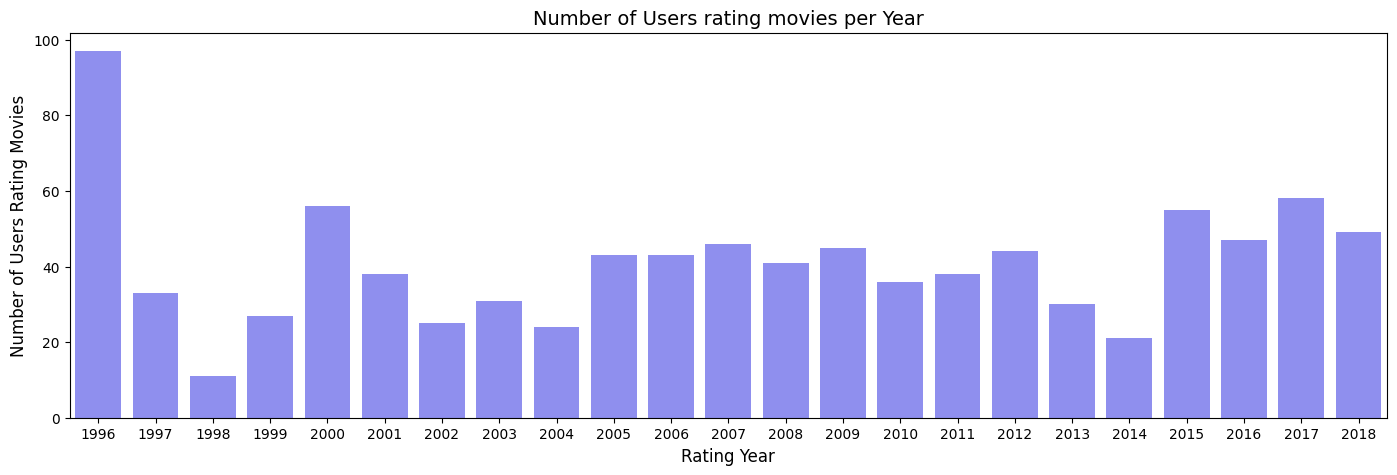

In [ ]:
# Create Plot with Number of Unique Users giving ratings
to_plot = df_ratings.groupby('year').nunique()['userId'].reset_index()
plt.figure(figsize=(17,5))
sns.barplot(x='year', y='userId', data=to_plot, color='blue', alpha=0.5)

# Set title and labels
plt.title('Number of Users rating movies per Year', size=14)
plt.xlabel('Rating Year', size=12)
plt.ylabel('Number of Users Rating Movies', size=12)

plt.show()


There aren't many users rating movies. Only about 40 active users per year on average

### Average Ratings by Release Year <a class="anchor" id="arry"></a>


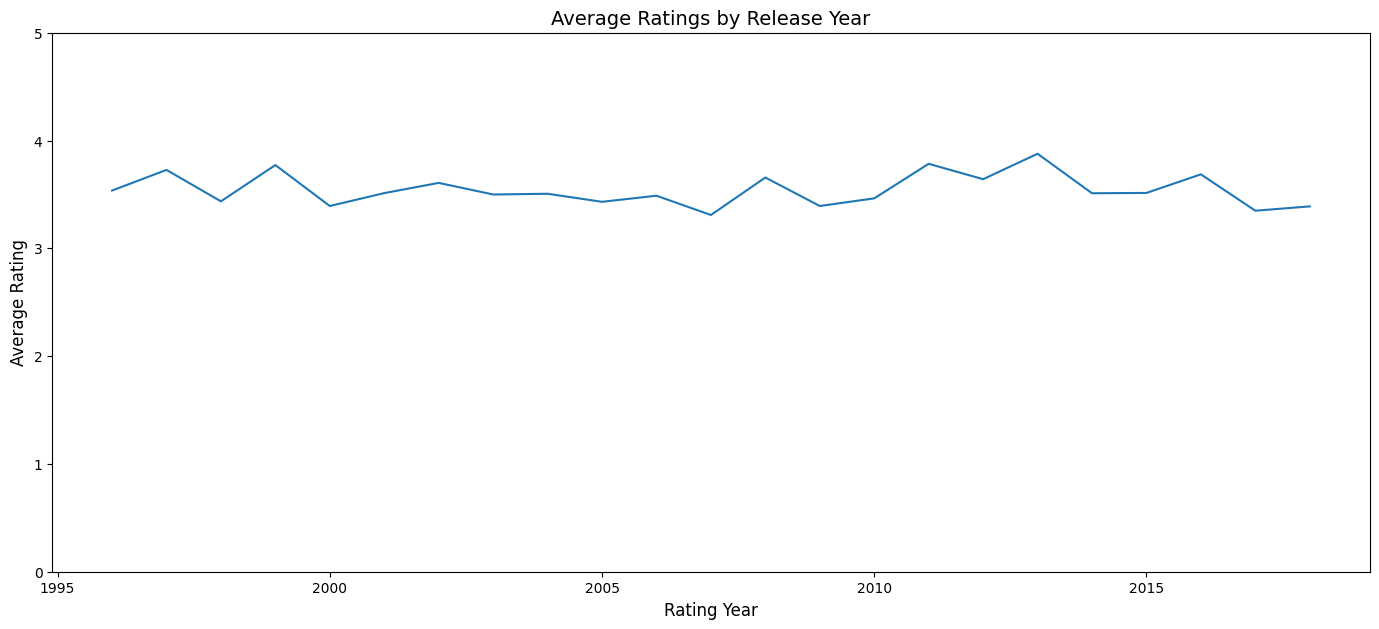

In [ ]:
# Sort the dataframe using the rating year
to_plot = df_ratings.copy()
to_plot['year'] = pd.to_numeric(to_plot['year'])
to_plot = to_plot.sort_values('year').reset_index(drop=True)

# Create plot
plt.figure(figsize=(17,7))
ax = sns.lineplot(x='year', y='rating', estimator=np.mean, data=to_plot, ci=None)

# Set title and labels
plt.title('Average Ratings by Release Year', size=14)
plt.xlabel('Rating Year', size=12)
plt.ylabel('Average Rating', size=12)
plt.yticks(range(0,6))
plt.show();

We can see that movie ratings per year remaine relatively stable over time.

# Recommender System <a class="anchor" id="rs"></a>
## Create Popularity Model <a class="anchor" id="pop"></a>

The first model we'll build is a simple popularity-based recommender. It ranks movies solely based on their popularity. However, raw average ratings can be misleading. For example, a movie with 100 ratings averaging 4.5 is far more reliable than one with only 2 ratings averaging 4.75. In this case, it's reasonable to argue that the first movie has a stronger overall rating, given the larger and more stable sample size.

To account for this, we'll use IMDB's Weighted Rating Formula, which adjusts for the number of ratings and provides a more balanced score.


##Mean vote across the whole dataset

In [ ]:
# Calculate Mean and Count the Number of Ratings to a given movie
mean_ratings_df = df_ratings.groupby('movieId').agg(avg_rating=('rating', 'mean'),
                                                count_rating=('rating', 'count')).reset_index()
# Calculate the Overall Average Rating
mean_ratings_df['overall_avg_rating'] = mean_ratings_df['avg_rating'].mean()
mean_ratings_df.head()

,movieId,avg_rating,count_rating,overall_avg_rating
0,1,3.920930,215,3.262448
1,2,3.431818,110,3.262448
2,3,3.259615,52,3.262448
3,4,2.357143,7,3.262448
4,5,3.071429,49,3.262448


####The minimum number of ratings required to be listed
To determine the minimum number of ratings a movie must have to be considered in our popularity model, we'll analyze the distribution of the number of ratings per movie. This helps us filter out movies with too few ratings to be statistically reliable, ensuring that only widely-rated films are included in the final ranking.



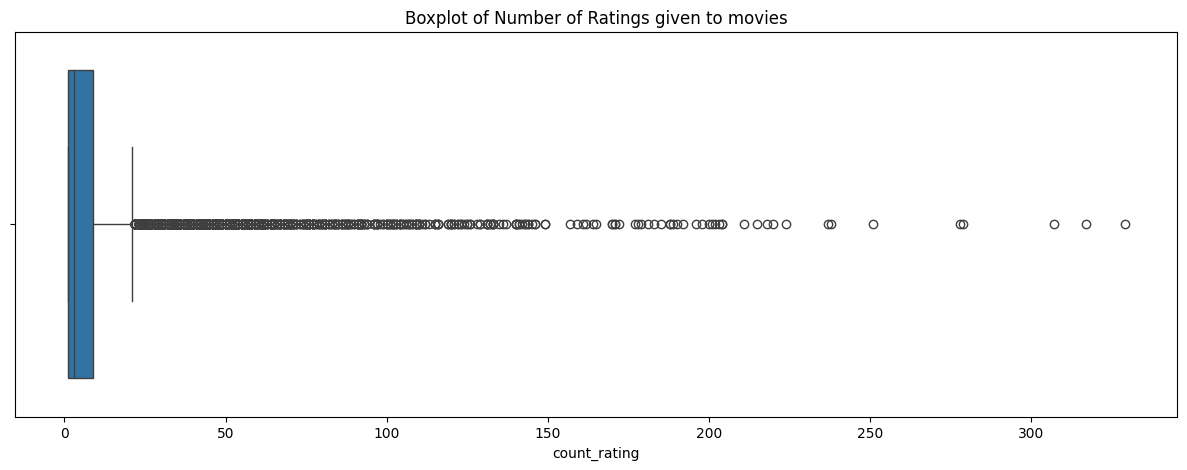

In [ ]:
# Plot
plt.figure(figsize=(15,5))
sns.boxplot(x=mean_ratings_df['count_rating'])
plt.title('Boxplot of Number of Ratings given to movies')
plt.show()

In [ ]:
# Calculate different quatiles
n_of_users = df_ratings['userId'].nunique()
n_of_movies = len(mean_ratings_df)
quantiles_list = []

for n in range(10, 100, 5):
    q = mean_ratings_df['count_rating'].quantile(n/100)
    n_of_selected_movies = len(mean_ratings_df[mean_ratings_df['count_rating'] >= q])
    quantiles_list.append([n, q, n_of_selected_movies])

pd.DataFrame(quantiles_list, columns=['quantile', 'quantile_value', 'number_of_movies'])

,quantile,quantile_value,number_of_movies
0,10,1.0,9724
1,15,1.0,9724
2,20,1.0,9724
3,25,1.0,9724
4,30,1.0,9724
5,35,1.0,9724
6,40,2.0,6278
7,45,2.0,6278
8,50,3.0,4980
9,55,3.0,4980


Before determining the minimum number of ratings a movie must have, we'll first examine how many movies users typically rate. This will give us context on user behavior and help guide a more informed choice for the threshold.



In [ ]:
df_ratings.groupby('userId').count()['movieId'].describe()

,movieId
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


The Median number of movies a user has rated is 70 movies and the 75th quantile is 168 movies.

Therefore, we are comfortable moving forward with having the Minimum Number of Ratings of 47 ratings since that represents 491 Movies which is more than most users have rated.

 We also experimented with lower thresholds of 17 and 27 ratings. However, those values led to suboptimal and inconsistent recommendations. After iterative testing, 47 proved to strike the best balance between coverage and recommendation quality.



#### Function to apply to the dataset

In [ ]:
def weighted_rating(df):
    """
    Calculates the IMDB's Weighted Rating using the following formula:
        (v / (v+m) * R) + (m / (m+v) * C)

    where:
    - v is the number of votes for the movie;
    - m is the minimum votes required to be listed in the chart;
    - R is the average rating of the movie; And
    - C is the mean vote across the whole report
    """
    v = df['count_rating']
    m = df['minimum_no_of_ratings']
    R = df['avg_rating']
    C = df['overall_avg_rating']

    return (v / (v+m) * R) + (m / (m+v) * C)

# Create Copy
popularity_df = mean_ratings_df.copy()

# Calculate the 95th quantile and the weighted rating
popularity_df['minimum_no_of_ratings'] = popularity_df['count_rating'].quantile(0.95)
popularity_df['weighted_rating'] = popularity_df.apply(weighted_rating, axis=1)

We are going to look at the top 10 movies with the highest ratings.

In [ ]:
# Grab the top 10 ids
top_ten_ids = popularity_df.sort_values('weighted_rating', ascending=False)['movieId'][:10].values

# Print them
for idx, movie_id in enumerate(top_ten_ids):
    print((idx + 1), df_movies[df_movies['movieId'] == movie_id]['title'].item())

1 Shawshank Redemption, The (1994)
2 Fight Club (1999)
3 Godfather, The (1972)
4 Star Wars: Episode IV - A New Hope (1977)
5 Pulp Fiction (1994)
6 Matrix, The (1999)
7 Schindler's List (1993)
8 Usual Suspects, The (1995)
9 Forrest Gump (1994)
10 Star Wars: Episode V - The Empire Strikes Back (1980)


##Content Based Filtering

In [ ]:
# Import dataset
df_movie_info = pd.read_csv('/content/movie_info_with_plot.csv')

#### Generate recommendations using only `description`

In [ ]:
#1
# Combine movie info with movie title
df_movie_info_title = pd.merge(df_movies_new[['movieId', 'title']], df_movie_info, on='movieId')


In [ ]:
#2
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

df_movie_info_title['keywords'] = (
    df_movie_info_title['keywords']
        .fillna('')            # replace NaN with empty string
        .astype(str)           # force to string
        .str.strip()           # trim whitespace
)

df_movie_info_title = df_movie_info_title[
    df_movie_info_title['keywords'].str.len() > 0
]

tf_kw = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    min_df=1,
    stop_words=None,
    token_pattern=r'(?u)\b\w+\b'
)

tfidf_matrix_kw = tf_kw.fit_transform(df_movie_info_title['keywords'])
cosine_sim_kw   = linear_kernel(tfidf_matrix_kw, tfidf_matrix_kw)

print("TF-IDF matrix shape for keywords:", tfidf_matrix_kw.shape)


TF-IDF matrix shape for keywords: (8679, 66803)


In [ ]:
#3
tf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    min_df=1,  # FIXED: changed from 0 to 1
    stop_words='english'
)
df_movie_info_title['description'] = df_movie_info_title['description'].fillna('')

tfidf_matrix = tf.fit_transform(df_movie_info_title['description'])


# Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the
# Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities
# since it is much faster.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#4
def get_recommendations(title, sim_scores, df_movie_info_title):
    # Use the correct title column; choose title_x or title_y depending on your setup
    if 'title' not in df_movie_info_title.columns:
        if 'title_x' in df_movie_info_title.columns:
            df_movie_info_title['title'] = df_movie_info_title['title_x']
        elif 'title_y' in df_movie_info_title.columns:
            df_movie_info_title['title'] = df_movie_info_title['title_y']
        else:
            raise KeyError("No suitable title column found.")

    # Safely find the index of the movie title
    matching_indices = df_movie_info_title.index[df_movie_info_title['title'] == title].tolist()
    if not matching_indices:
        raise ValueError(f"Title '{title}' not found in dataset.")

    idx = matching_indices[0]

    # Get similarity scores for this movie
    scores = list(enumerate(sim_scores[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    # Skip the first one (it's the movie itself), and filter out zero-score entries
    top_similar = [i for i in scores[1:] if i[1] > 0][:10]

    movie_indices = [i[0] for i in top_similar]
    recommended_titles = df_movie_info_title.iloc[movie_indices][['title']]

    return recommended_titles


In [ ]:
#5
get_recommendations('Toy Story', cosine_sim, df_movie_info_title)

,title
7330,Toy Story 3
2351,Toy Story 2
5954,"40-Year-Old Virgin, The"
838,Rebel Without a Cause
6401,Factory Girl
2388,Man on the Moon
1509,Condorman
4759,Rivers and Tides
427,Malice
9162,Welcome to Happiness


Some of the movies make sense but we were surprised to see `40-Year-Old Virgin, The`

In [ ]:
#6
get_recommendations('Dark Knight, The', cosine_sim, df_movie_info_title)

,title
6756,"Dark Knight Rises, The"
5173,Batman Begins
6782,"Flowers of War, The (Jin líng shí san chai)"
5539,"Prestige, The"
1091,In the Company of Men
1410,"Muppet Christmas Carol, The"
6573,Battle: Los Angeles
4107,"Italian Job, The"
5227,"Brothers Grimm, The"
5691,Rescue Dawn


> Depending exclusively on movie descriptions for recommendations can be problematic. For example, a search for Batman might return every Batman movie ignoring differences in release year, cast, or other key details resulting in overly general and less relevant suggestions.

#### Generate recommendations using only `cast`
**Handling Duplicate Cast Members Across Roles:**

Some individuals appear multiple times in the cast list due to holding multiple roles (e.g., Director and Writer). While this information might be valuable, it can displace other important cast members. To maintain a balanced and representative list, we keep only one instance per cast_name per movie.

**Filtering Out Less Relevant Cast Members:**

Cast members who appear in only a single movie don't provide strong signals for recommendation, as there's no opportunity to draw connections across films. To address this, we retain only cast members who have participated in more than one movie in the dataset, improving the model’s ability to recognize meaningful patterns.

**Selecting the Top 15 Cast Members:**

We limit the cast list to the top 15 members per movie. Thankfully, IMDb’s cast data is already sorted by importance. While the exact sorting criteria aren't publicly available, manual checks confirm that it reliably ranks the most influential contributors at the top. We take advantage of this ordering to prioritize the most relevant figures in our recommendation engine.



In [ ]:
#7
# Import cast
df_movie_cast = pd.read_csv('/content/cast_with_order_real.csv')

# We have found duplicates and we are going to drop them and
df_movie_cast = df_movie_cast.drop_duplicates(['movieId', 'cast_name'])
print('Number of Rows (All Cast Members):', len(df_movie_cast))

# Keep only cast members in more than one movie
cast_count = df_movie_cast.groupby('cast_name').count()['movieId'].reset_index()
cast_count.columns = ['cast_name', 'count']
cast_name_filtered = list(cast_count[cast_count['count'] > 1]['cast_name'])
cast_name_filtered = set(cast_name_filtered)
df_movie_cast = df_movie_cast[df_movie_cast['cast_name'].isin(cast_name_filtered)]
print('Filtered number of Rows (only members who have done more than one movie):', len(df_movie_cast))

# Create a new column with new order
df_movie_cast['new_order'] = df_movie_cast.groupby('movieId').rank()['cast_order']

# After reviewing different casts we are going to keep the first 15 cast members
# We found that to be a good number
df_movie_cast = df_movie_cast[df_movie_cast['new_order'] < 15]
print('Further filtered number of Rows (top 15 cast members of movies):', len(df_movie_cast))

Number of Rows (All Cast Members): 36696
Filtered number of Rows (only members who have done more than one movie): 27588
Further filtered number of Rows (top 15 cast members of movies): 27588


#### Weighting Cast Members by Importance
Since IMDb’s cast list is already sorted by importance, we can leverage this order by assigning more weight to higher-ranked cast members. To do this, we repeat the cast_name multiple times based on their position in the list—ensuring that key figures have a greater influence in the recommendation model.

To be specific, we apply the following formula to determine how many times each cast member's name should appear:

Weight = 15 − (cast_order − 1)

This means:

First cast member → repeated 15 times

Second cast member → repeated 14 times

Third cast member → repeated 13 times

... and so on

This weighting strategy helps the model prioritize movies with more prominent cast overlaps.

**Note: The number 15 is an arbitrary upper limit that may be adjusted based on performance during model testing.**

In [ ]:
#8
# Create Multiplier to give top cast members more weight
df_movie_cast['multiplier'] = 15 - (df_movie_cast['new_order'] - 1)
df_movie_cast['clean_cast_name'] = df_movie_cast['cast_name'].str.lower().str.replace(' ', '')
df_movie_cast['weighted_cast'] = df_movie_cast.apply(lambda x: (x['clean_cast_name'] + ' ')
                                                     * int(x['multiplier'])
                                                     , axis=1)

# Create a column with weighted cast
df_movie_cast_modified = df_movie_cast.groupby('movieId')['weighted_cast']\
                                      .apply(lambda x: ' '.join(x))\
                                      .reset_index()

df_movie_cast_modified.iloc[0]['weighted_cast']

'tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks tomhanks  timallen timallen timallen timallen timallen timallen timallen timallen timallen timallen timallen timallen timallen timallen  donrickles donrickles donrickles donrickles donrickles donrickles donrickles donrickles donrickles donrickles donrickles donrickles donrickles  jimvarney jimvarney jimvarney jimvarney jimvarney jimvarney jimvarney jimvarney jimvarney jimvarney jimvarney jimvarney '

As shown above, we repeat cast member names to emphasize the importance of higher-ranked individuals, effectively giving them more weight in the recommendation process..

In [ ]:
#9
# Refit TD-IDF model
df_movie_cast_test = pd.merge(df_movie_info_title, df_movie_cast_modified, on='movieId')
tfidf_matrix = tf.fit_transform(df_movie_cast_test['weighted_cast'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#10
get_recommendations('Toy Story', cosine_sim, df_movie_cast_test)

,title
6412,Toy Story 3
2143,Toy Story 2
2004,Return with Honor
2381,Bachelor Party
2986,Ernest Saves Christmas
6146,Ernest Rides Again
4751,"Polar Express, The"
2757,Ernest Goes to Camp
2586,Kelly's Heroes
3550,Ernest Scared Stupid


In [ ]:
#11
get_recommendations('Dark Knight, The', cosine_sim, df_movie_cast_test)

,title
6782,"Flowers of War, The (Jin líng shí san chai)"
6756,"Dark Knight Rises, The"
5173,Batman Begins
5539,"Prestige, The"
1410,"Muppet Christmas Carol, The"
4107,"Italian Job, The"
1091,In the Company of Men
6573,Battle: Los Angeles
5227,"Brothers Grimm, The"
5691,Rescue Dawn


#### Conclusions:
The recommendations are starting to make more sense. For example, I would have expected Toy Story to return its sequels first, but instead it recommends A Bug’s Life. That’s still reasonable, considering both films share the same director and several cast members.

The Dark Knight also received strong recommendations. However, the model seems to be overfitting to the director, in this case, Christopher Nolan.

This issue likely stems from the way we’re weighting cast members by their order—placing too much emphasis on those at the top of the list (often the director). This is something I plan to revisit and fine-tune in future iterations to ensure a more balanced influence across cast roles.


#### Generate recommendations based solely on cast member pairs
The assumption is that movies sharing the same actor pairs are likely to be more closely related.

In [ ]:
#12
def cast_combinations(df_movie_cast,
                      no_of_cast_members=10,
                      no_of_elements=2):
    cast_rows = df_movie_cast.iloc[:no_of_cast_members]
    lst_of_combinations = [i for i in combinations(list(cast_rows['cast_name']), no_of_elements)]
    lst_of_combinations = [''.join(sorted(i)) for i in lst_of_combinations]
    lst_of_combinations = [i.lower().replace(' ', '') for i in lst_of_combinations]

    return (" ".join(lst_of_combinations) + " ") * no_of_cast_members

In [ ]:
#13
# Create all different combinations of pairs
df_movie_cast_combinations = df_movie_cast.groupby('movieId').apply(lambda x: cast_combinations(x, 5, 2))
df_movie_cast_combinations = df_movie_cast_combinations.reset_index()
df_movie_cast_combinations.columns = ['movieId', 'cast_combinations']
df_movie_cast_combinations.head()

,movieId,cast_combinations
0,1,timallentomhanks donricklestomhanks jimvarneyt...
1,2,kirstendunstrobinwilliams kirstendunstrobinwil...
2,3,jacklemmonwaltermatthau ann-margretwaltermatth...
3,4,angelabassettwhitneyhouston lorettadevinewhitn...
4,5,dianekeatonstevemartin martinshortstevemartin ...


In [ ]:
#14
# Refit TD-IDF model
df_movie_cast_pairs_test = pd.merge(df_movie_info_title, df_movie_cast_combinations, on='movieId')
tfidf_matrix = tf.fit_transform(df_movie_cast_pairs_test['cast_combinations'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#15
get_recommendations('Toy Story', cosine_sim, df_movie_cast_pairs_test)

,title
2143,Toy Story 2
6412,Toy Story 3


In [ ]:
#16
get_recommendations('Dark Knight, The', cosine_sim, df_movie_cast_pairs_test)

,title
5539,"Prestige, The"
6756,"Dark Knight Rises, The"
5173,Batman Begins


#### Generate recommendations using only `movie_keywords`

In [ ]:
#17
nltk.download('wordnet')
lemma = nltk.wordnet.WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df_movie_info_title['keywords'].head(10).tolist()


['jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life',
 "board game disappearance based on children's book new home recluse giant insect",
 'fishing best friend duringcreditsstinger old men',
 'based on novel interracial relationship single mother divorce chick flick',
 'baby midlife crisis confidence aging daughter mother daughter relationship pregnancy contraception gynecologist',
 'robbery detective bank obsession chase shooting thief honor murder suspense heist betrayal money gang cat and mouse criminal mastermind cult film ex-con heist movie one last job loner bank job neo-noir gun fight crime epic',
 'paris brother brother relationship chauffeur long island fusion millionaire',
 'terrorist hostage explosive vice president',
 'cuba falsely accused secret identity computer virus secret base secret intelligence service kgb satellite special car cossack electromagnetic pulse time bomb st. petersburg russia ejection seat red army',
 'white house usa pr

In [ ]:
#18
df_movie_info_title['keywords'] = df_movie_info_title.apply(
    lambda x: [lemma.lemmatize(i) for i in x['keywords'].split()],
    axis=1
)

# Join the lemmatized words back into a single string
df_movie_info_title['keywords'] = df_movie_info_title['keywords'].apply(lambda x: ' '.join(x))


In [ ]:
#19
# Refit TD-IDF model
tfidf_matrix = tf.fit_transform(df_movie_info_title['keywords'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [ ]:
#20
get_recommendations('Toy Story', cosine_sim, df_movie_info_title)

,title
1464,Child's Play 2
1398,Small Soldiers
1465,Child's Play 3
1720,Bride of Chucky (Child's Play 4)
8493,Annabelle
7890,Ted
7330,Toy Story 3
53,"Indian in the Cupboard, The"
5368,Seed of Chucky (Child's Play 5)
2325,Babes in Toyland



#### Combine all fields

In [ ]:
# Merge all necessary dataframes
df_movie_info_title = pd.merge(df_movie_cast_modified, df_movie_info_title, on='movieId')
df_movie_info_title = pd.merge(df_movie_info_title,
                               df_movie_cast_combinations[['movieId', 'cast_combinations']],
                               on='movieId')

In [ ]:
# Create a list with the movies that will be tested
test_movies = ['Toy Story',
               'Dark Knight, The',
               'Godfather, The',
               'Shawshank Redemption, The',
               'Fight Club',
               'Pulp Fiction',
               'Matrix, The',
               'Forrest Gump',
               'Usual Suspects, The']

# Content field names
field_names = ['title', 'description',
               'movie_plot', 'keywords',
               'cast_combinations', 'weighted_cast']

In [ ]:
# Create all different combinations of the field names, from having only one to all
field_combs = []

for i in range(1,7):
    for comb in list(combinations(field_names, i)):
        field_combs.append(comb)

print('Number of Field Combinations:', len(field_combs))

Number of Field Combinations: 63


Now it's time to iterate through the different combinations of content fields, fit the model and get recommendations.

In [ ]:
results = []
length = len(field_combs)

# Loop through the different combinations of fields
for idx, field_comb in enumerate(field_combs):

    # Create 'features' with the chosen combination
    temp_df = df_movie_info_title.copy()
    temp_df['features'] = temp_df[list(field_comb)].agg(' '.join, axis=1)

    # Refit TF-IDF
    tfidf_matrix = tf.fit_transform(temp_df['features'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Generate recommendations for the test movies and reformat the dataframe to store results
    for test_movie in test_movies:
        reco = get_recommendations(test_movie, cosine_sim, temp_df)
        reco = reco.reset_index(drop=True).transpose().reset_index(drop=True)
        reco['target_movie'] = test_movie
        reco['combinations'] = ", ".join(list(field_comb))
        results.append(reco)

    # Print completion
    if idx % 10 == 0:
        print('Completion:', round(((idx+1)/length),2))

Completion: 0.02
Completion: 0.17
Completion: 0.33
Completion: 0.49
Completion: 0.65
Completion: 0.81
Completion: 0.97


In [ ]:
# Put results together
comb_results_df = pd.concat(results)
comb_results_df.columns = ['rec_' + str(i) for i in range(9)] + list(comb_results_df.columns[9:])

Analyze `Toy Story`

We'll begin by ensuring that the other two Toy Story movies appear in the top 3 recommendations.

In [ ]:
comb_results_df[(comb_results_df['target_movie'] == 'Toy Story') &

                # Toy Story 2 has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Toy Story 2')) |
               (comb_results_df['rec_1'].str.contains('Toy Story 2')) |
               (comb_results_df['rec_2'].str.contains('Toy Story 2'))) &

                # Toy Story 3 has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Toy Story 3')) |
               (comb_results_df['rec_1'].str.contains('Toy Story 3')) |
               (comb_results_df['rec_2'].str.contains('Toy Story 3')))
               ]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,9,target_movie,combinations
0,Toy Story 2,Toy Story 3,"Toy, The",L.A. Story,"Story of Us, The",Toy Soldiers,Love Story,Ghost Story,"Christmas Story, A",True Story,Toy Story,title
0,Toy Story 3,Toy Story 2,"40-Year-Old Virgin, The",Rebel Without a Cause,Factory Girl,Man on the Moon,Condorman,Malice,Welcome to Happiness,For Love or Money,Toy Story,description
0,Toy Story 2,Toy Story 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Toy Story,cast_combinations
0,Toy Story 3,Toy Story 2,Return with Honor,Bachelor Party,Ernest Saves Christmas,Ernest Rides Again,"Polar Express, The",Ernest Goes to Camp,Kelly's Heroes,Ernest Scared Stupid,Toy Story,weighted_cast
0,Toy Story 2,Toy Story 3,"40-Year-Old Virgin, The",Rebel Without a Cause,I Shot Andy Warhol,Factory Girl,Condorman,Man on the Moon,Malice,For Love or Money,Toy Story,"title, description"
0,Toy Story 3,Toy Story 2,Transformers: The Movie,Dolls,Ted,"Toy, The",Casper,Toy Soldiers,Rabbit Hole,Child's Play 2,Toy Story,"title, movie_plot"
0,Toy Story 2,Toy Story 3,"NeverEnding Story, The",American: The Bill Hicks Story,"Story of Film: An Odyssey, The",Perfume: The Story of a Murderer,Crime Story (Zhong an zu),Fish Story (Fisshu sutôrî),Empire of Dreams: The Story of the 'Star Wars'...,"Toy, The",Toy Story,"title, cast_combinations"
0,Toy Story 3,Toy Story 2,Return with Honor,Bachelor Party,Ernest Saves Christmas,Ernest Rides Again,"Polar Express, The",Ernest Goes to Camp,Kelly's Heroes,Ernest Scared Stupid,Toy Story,"title, weighted_cast"
0,Toy Story 2,Toy Story 3,"40-Year-Old Virgin, The",Dolls,Transformers: The Movie,Roommates,"Wild, The",Small Soldiers,Rebel Without a Cause,"Indian in the Cupboard, The",Toy Story,"description, movie_plot"
0,Toy Story 2,Toy Story 3,Small Soldiers,"40-Year-Old Virgin, The",Child's Play 2,Child's Play 3,Child's Play,Toys,Dolls,Bride of Chucky (Child's Play 4),Toy Story,"description, keywords"


Overall, the recommendations are quite strong. However, the appearance of `Child's Play` in some results is problematic, as it's a horror movie and likely not contextually relevant. It may be worthwhile to introduce a genre-based filter to avoid such mismatches.

In this specific case, the issue seems to occur when using the `movie_description` or `plot` features without including cast information, which suggests that relying solely on text-based features can lead to less accurate genre alignment.

#### Next, We will analyze The Dark Knight.
We'll follow the same approach as before, ensuring that `The Dark Knight Rises` and `Batman Begins` appear in the top 3 recommendations.

In [ ]:
comb_results_df[(comb_results_df['target_movie'] == 'Dark Knight, The') &

                # Dark Knight has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Dark Knight')) |
               (comb_results_df['rec_1'].str.contains('Dark Knight')) |
               (comb_results_df['rec_2'].str.contains('Dark Knight'))) &

                # Batman Begins has to be in the top 3 recommendations
               ((comb_results_df['rec_0'].str.contains('Batman Begins')) |
               (comb_results_df['rec_1'].str.contains('Batman Begins')) |
               (comb_results_df['rec_2'].str.contains('Batman Begins')))]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,9,target_movie,combinations
0,"Prestige, The","Dark Knight Rises, The",Batman Begins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Dark Knight, The",cast_combinations
0,"Flowers of War, The (Jin líng shí san chai)","Dark Knight Rises, The",Batman Begins,"Prestige, The","Muppet Christmas Carol, The","Italian Job, The",In the Company of Men,Battle: Los Angeles,"Brothers Grimm, The",Rescue Dawn,"Dark Knight, The",weighted_cast
0,Batman Begins,Batman Returns,"Dark Knight Rises, The",Batman: Under the Red Hood,Batman: Gotham Knight,Batman,Batman & Robin,Batman: Mask of the Phantasm,Justice League: The New Frontier (,Batman vs. Robin,"Dark Knight, The","title, keywords"
0,"Dark Knight Rises, The","Prestige, The",Batman Begins,Taxi to the Dark Side,Bloodsport: The Dark Kumite,Dark Blue World (Tmavomodrý svet),"Batman: The Dark Knight Returns, Part 1","Batman: The Dark Knight Returns, Part 2","Cry in the Dark, A",The Dark Valley,"Dark Knight, The","title, cast_combinations"
0,"Dark Knight Rises, The",Batman Begins,"Flowers of War, The (Jin líng shí san chai)","Prestige, The","Italian Job, The","Muppet Christmas Carol, The",In the Company of Men,Battle: Los Angeles,"Brothers Grimm, The",Rescue Dawn,"Dark Knight, The","title, weighted_cast"
0,"Dark Knight Rises, The",Batman: Under the Red Hood,Batman Begins,Batman Returns,Batman Forever,Batman,The Flash 2 - Revenge of the Trickster,Batman: The Killing Joke,"Batman/Superman Movie, The",Batman & Robin,"Dark Knight, The","description, keywords"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",To End All Wars,Batman Returns,Batman: Year One,Batman Forever,"Rookie, The","Batman/Superman Movie, The",LEGO Batman: The Movie - DC Heroes Unite,"Dark Knight, The","description, cast_combinations"
0,"Dark Knight Rises, The",Batman Begins,"Flowers of War, The (Jin líng shí san chai)","Prestige, The","Muppet Christmas Carol, The",In the Company of Men,Battle: Los Angeles,"Italian Job, The","Brothers Grimm, The",Rescue Dawn,"Dark Knight, The","description, weighted_cast"
0,"Dark Knight Rises, The",Batman Begins,Batman: Gotham Knight,Justice League: The New Frontier (,Kick-Ass 2,Batman: Under the Red Hood,Batman: Mask of the Phantasm,Batman Returns,Batman vs. Robin,Wonder Woman,"Dark Knight, The","movie_plot, keywords"
0,"Dark Knight Rises, The",Batman Begins,"Prestige, The",Louis C.K.: Chewed Up,Max Manus,Gomorrah (Gomorra),Gran Torino,Fireproof,"Shepherd: Border Patrol, The","Cottage, The","Dark Knight, The","movie_plot, cast_combinations"


In [ ]:
comb_results_df[(comb_results_df['combinations'] == 'cast_combinations, weighted_cast')]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,9,target_movie,combinations
0,Return with Honor,Bachelor Party,Toy Story 3,Toy Story 2,Ernest Saves Christmas,Ernest Rides Again,"Polar Express, The",Ernest Goes to Camp,Ernest Scared Stupid,Extremely Loud and Incredibly Close,Toy Story,"cast_combinations, weighted_cast"
0,"Flowers of War, The (Jin líng shí san chai)","Muppet Christmas Carol, The","Italian Job, The","Dark Knight Rises, The",Batman Begins,In the Company of Men,Battle: Los Angeles,"Prestige, The","Brothers Grimm, The",Rescue Dawn,"Dark Knight, The","cast_combinations, weighted_cast"
0,Serpico,Don Juan DeMarco,Guys and Dolls,"Teahouse of the August Moon, The",One-Eyed Jacks,The Wild One,"Island of Dr. Moreau, The","Freshman, The",Christopher Columbus: The Discovery,Apocalypse Now,"Godfather, The","cast_combinations, weighted_cast"
0,Catch a Fire,Tenacious D in The Pick of Destiny,John Dies at the End,LEGO Batman: The Movie - DC Heroes Unite,Erik the Viking,Code 46,"Burrowers, The",Tapeheads,Patch Adams,"SpongeBob SquarePants Movie, The","Shawshank Redemption, The","cast_combinations, weighted_cast"
0,"Painted Veil, The",Moonrise Kingdom,War Machine,"Incredible Hulk, The",25th Hour,"Illusionist, The",Pride and Glory,Everyone Says I Love You,Red Dragon,"Score, The",Fight Club,"cast_combinations, weighted_cast"
0,African Cats,I Am Not Your Negro,Basic,Unbreakable,Die Hard: With a Vengeance,Kite,The Hateful Eight,School Daze,Lakeview Terrace,Changing Lanes,Pulp Fiction,"cast_combinations, weighted_cast"
0,"Matrix Revolutions, The","Matrix Reloaded, The","Animatrix, The",Frankenstein,Memento,Red Planet,Fido,Silent Hill: Revelation 3D,Suspect Zero,Disturbia,"Matrix, The","cast_combinations, weighted_cast"
0,Return with Honor,Bachelor Party,Apollo 13,"Polar Express, The",The Purge: Election Year,"Stand, The",Extremely Loud and Incredibly Close,You've Got Mail,Sleepless in Seattle,Angels & Demons,Forrest Gump,"cast_combinations, weighted_cast"
0,End of Days,P.S.,"Flintstones in Viva Rock Vegas, The",Threesome,Fled,One Tough Cop,Cool World,House Arrest,Hostage,Gothic,"Usual Suspects, The","cast_combinations, weighted_cast"


We have a problem that is that it's very much overfitting the Director of the movies

Now, we'll validate the importance of using `cast` by reviewing the recommendations without any cast-related features to see how their quality compares.

In [ ]:
comb_results_df[(~comb_results_df['combinations'].str.contains('cast')) &
               (comb_results_df['target_movie'] == 'Toy Story')]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,9,target_movie,combinations
0,Toy Story 2,Toy Story 3,"Toy, The",L.A. Story,"Story of Us, The",Toy Soldiers,Love Story,Ghost Story,"Christmas Story, A",True Story,Toy Story,title
0,Toy Story 3,Toy Story 2,"40-Year-Old Virgin, The",Rebel Without a Cause,Factory Girl,Man on the Moon,Condorman,Malice,Welcome to Happiness,For Love or Money,Toy Story,description
0,Toy Story 3,Casper,Transformers: The Movie,Toy Story 2,"Pyromaniac's Love Story, A",Ted,Dolls,Jumanji,Land Before Time III: The Time of the Great Gi...,Balto,Toy Story,movie_plot
0,Child's Play 2,Small Soldiers,Child's Play 3,Bride of Chucky (Child's Play 4),Annabelle,Ted,Toy Story 3,"Indian in the Cupboard, The",Seed of Chucky (Child's Play 5),Babes in Toyland,Toy Story,keywords
0,Toy Story 2,Toy Story 3,"40-Year-Old Virgin, The",Rebel Without a Cause,I Shot Andy Warhol,Factory Girl,Condorman,Man on the Moon,Malice,For Love or Money,Toy Story,"title, description"
0,Toy Story 3,Toy Story 2,Transformers: The Movie,Dolls,Ted,"Toy, The",Casper,Toy Soldiers,Rabbit Hole,Child's Play 2,Toy Story,"title, movie_plot"
0,Small Soldiers,Child's Play 2,Toy Story 3,Child's Play 3,Annabelle,Toy Story 2,Bride of Chucky (Child's Play 4),Ted,Child's Play,Toys,Toy Story,"title, keywords"
0,Toy Story 2,Toy Story 3,"40-Year-Old Virgin, The",Dolls,Transformers: The Movie,Roommates,"Wild, The",Small Soldiers,Rebel Without a Cause,"Indian in the Cupboard, The",Toy Story,"description, movie_plot"
0,Toy Story 2,Toy Story 3,Small Soldiers,"40-Year-Old Virgin, The",Child's Play 2,Child's Play 3,Child's Play,Toys,Dolls,Bride of Chucky (Child's Play 4),Toy Story,"description, keywords"
0,Toy Story 3,Small Soldiers,Child's Play 2,Transformers: The Movie,Dolls,Ted,Toy Story 2,Child's Play,Toys,"Phantom Tollbooth, The",Toy Story,"movie_plot, keywords"


In [ ]:
comb_results_df[(~comb_results_df['combinations'].str.contains('cast')) &
               (comb_results_df['target_movie'] == 'Pulp Fiction')]

,rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,9,target_movie,combinations
0,Stranger than Fiction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pulp Fiction,title
0,Prizzi's Honor,"Wackness, The",Moll Flanders,Kill Me Three Times,Branded to Kill (Koroshi no rakuin),"Sting, The",Ghost Dog: The Way of the Samurai,Sliding Doors,Killer Joe,"Liability, The",Pulp Fiction,description
0,Amateur,"Air Up There, The",Angie,Above the Rim,Fresh,It's Pat,Blankman,Killing Zoe,"Last Seduction, The",Trapped in Paradise,Pulp Fiction,movie_plot
0,Psycho,Precious Cargo,"Bag Man, The",Thursday,"Cook the Thief His Wife & Her Lover, The",Sliding Doors,Gotti,Pusher,Saving Grace,"French Connection, The",Pulp Fiction,keywords
0,Good Burger,Moll Flanders,"Wackness, The",Prizzi's Honor,"Whole Wide World, The",Kill Me Three Times,"Sting, The",Sliding Doors,"Liability, The",True Stories,Pulp Fiction,"title, description"
0,"Air Up There, The",Amateur,Stranger than Fiction,Fresh,Angie,"Last Seduction, The",Only You,It's Pat,Above the Rim,My Girl 2,Pulp Fiction,"title, movie_plot"
0,Psycho,"Bag Man, The",Precious Cargo,Sliding Doors,Thursday,Gotti,"French Connection, The",Pusher,"Town, The",Rush,Pulp Fiction,"title, keywords"
0,Above the Rim,Trapped in Paradise,Clear and Present Danger,"Wackness, The",Pusher,Shallow Grave,Super,Fat City,"Boxer, The",Jason's Lyric,Pulp Fiction,"description, movie_plot"
0,"French Connection, The",Sliding Doors,"Wackness, The",Pusher,Trainspotting,Ali,Red Heat,Training Day,Prizzi's Honor,"Fighter, The",Pulp Fiction,"description, keywords"
0,Thursday,Fresh,Fat City,Saving Grace,Pusher,Amateur,"Air Up There, The",Another 48 Hrs.,Kindergarten Cop,Rocky III,Pulp Fiction,"movie_plot, keywords"


**Conclusion: Cast Features Have a Significant Impact**

The analysis clearly shows that incorporating cast information greatly improves recommendation quality. When evaluating recommendations generated without any cast-related features, many of the results were irrelevant or contextually weak.

This highlights the importance of including cast data in the model. However, there's a small caveat: the current weighting method gives too much influence to the top-ranked cast members, which often results in an overrepresentation of movies from the same director. This suggests the need for fine-tuning the weighting strategy to achieve a better balance.

### Fine tuning the model


In [ ]:
# Import cast
df_movie_cast_simulation = pd.read_csv('/content/cast_with_order_real.csv')

# We have found duplicates and we going to drop them and
df_movie_cast_simulation = df_movie_cast_simulation.drop_duplicates(['movieId', 'cast_name'])
df_movie_info_simulation = df_movie_info_title.copy()

In [ ]:
def get_recommendations_simulation(all_titles, cosine_sim, df_movie_info_simulation):

    # Convert consine_sim to dataframe
    df_cosine_sim = pd.DataFrame(cosine_sim)
    df_cosine_sim.columns = df_movie_info_simulation['movieId'].to_list()
    df_cosine_sim = pd.merge(df_cosine_sim,
                              df_movie_info_simulation[['movieId']],
                              right_index=True,
                              left_index=True)

    # List of movieIds to come up with recommendations
    target_movieIds = df_movie_info_simulation.loc[df_movie_info_simulation['title'].isin(all_titles)]
    target_movieIds = target_movieIds['movieId'].values

    # Keep only scores for target movies and transform dataframe
    target_rows = df_cosine_sim[df_cosine_sim['movieId'].isin(target_movieIds)]
    target_rows = target_rows.set_index('movieId')
    target_rows = target_rows.transpose().reset_index()
    target_rows = target_rows.rename(columns={'index': 'target_movieId'})

    # Create set with movieId and score for each recommendation
    for col in target_rows.columns[1:]:
        temp_col = target_rows[['target_movieId', col]].sort_values(col, ascending=False)
        target_rows[col] = temp_col.apply(lambda x: (x[col], x['target_movieId']),
                                          axis=1).reset_index(drop=True)

    # Keep only the first 5 recommendations
    target_rows = target_rows.drop('target_movieId', axis=1)
    target_rows = target_rows.iloc[1:]
    target_rows = target_rows.transpose().reset_index()
    target_rows = target_rows.iloc[: , :6]

    # Create dictionary with movieId and title
    movieId_titles_dict = df_movie_info_simulation[['movieId', 'title']].set_index('movieId').to_dict('index')

    # Create columns with movieIds and scores for recommendations
    # null if the score is lower than 0.01
    for col in range(1,6):
        col_movieId = 'rec_' + str(col) + '_movieId'
        col_score = 'rec_' + str(col) + '_score'
        col_title = 'rec_' + str(col) + '_title'
        target_rows[col_movieId] = target_rows.apply(lambda x: int(x[col][1]) if x[col][0] > 0.01 else np.nan,
                                                     axis=1)
        target_rows[col_score] = target_rows.apply(lambda x: round(x[col][0], 2) if x[col][0] > 0.01 else np.nan,
                                                   axis=1)
        target_rows[col_title] = target_rows.apply(lambda x: movieId_titles_dict[x[col_movieId]]['title'] \
                                                   if np.isnan(x[col_movieId]) == False else np.nan,
                                                     axis=1)

    # Add target title
    target_rows = pd.merge(target_rows, df_movie_info_simulation[['movieId', 'title']], on='movieId')
    target_rows = target_rows.rename(columns={'title': 'target_title'})

    # Create dataframes with recommendations and scores
    rec_titles_columns = [('rec_' + str(i) + '_title') for i in range(1,6)]
    rec_titles_columns.append('target_title')
    rec_scores_columns = [('rec_' + str(i) + '_score') for i in range(1,6)]
    rec_scores_columns.append('target_title')
    recommendations = target_rows[rec_titles_columns]
    df_movie_scores = target_rows[rec_scores_columns]

    return recommendations, df_movie_scores

In [ ]:
def simulation(no_of_cast_members=15,
               no_of_cast_member_movies=1,
               cast_order_weight=1,
               cast_combination_members=5,
               cast_combination_group_members=2,
               test_movies=['Toy Story',
                           'Dark Knight, The',
                           'Godfather, The',
                           'Shawshank Redemption, The',
                           'Fight Club',
                           'Pulp Fiction',
                           'Matrix, The',
                           'Forrest Gump',
                           'Usual Suspects, The'],
               df_movie_info_simulation=df_movie_info_simulation,
               df_movie_cast_simulation=df_movie_cast_simulation):

    # Keep only cast members in more than one movie
    cast_count = df_movie_cast_simulation.groupby('cast_name').count()['movieId'].reset_index()
    cast_count.columns = ['cast_name', 'count']
    cast_name_filtered = list(cast_count[cast_count['count'] > no_of_cast_member_movies]['cast_name'])
    cast_name_filtered = set(cast_name_filtered)
    df_filtered_cast = df_movie_cast_simulation[df_movie_cast_simulation['cast_name'].isin(cast_name_filtered)]

    # Create a new column with new order
    df_filtered_cast['new_order'] = df_filtered_cast.groupby('movieId').rank()['cast_order']

    # After reviewing different casts we are going to keep the first no_of_cast_members cast members
    # We found that to be a good number
    df_filtered_cast = df_filtered_cast[df_filtered_cast['new_order'] < no_of_cast_members]

    # Define multiplier weight value
    cast_order_multiplier_value = no_of_cast_members // cast_order_weight

    # Create Multiplier to give top cast members more weight
    df_filtered_cast['multiplier'] = cast_order_multiplier_value - \
                                    (df_filtered_cast['new_order'] // cast_order_weight)
    df_filtered_cast['clean_cast_name'] = df_filtered_cast['cast_name'].str.lower().str.replace(' ', '')
    df_filtered_cast['weighted_cast'] = df_filtered_cast.apply(lambda x: (x['clean_cast_name'] + ' ')
                                                               * int(x['multiplier'])
                                                               , axis=1)

    # Come up with cast combinations
    df_movie_cast_combinations = df_filtered_cast.groupby('movieId')\
                                                 .apply(lambda x: cast_combinations(x,
                                                                                    cast_combination_members,
                                                                                    cast_combination_group_members))
    df_movie_cast_combinations = df_movie_cast_combinations.reset_index()
    df_movie_cast_combinations.columns = ['movieId', 'cast_combinations']

    # Create a column with weighted cast
    df_movie_cast_modified = df_filtered_cast.groupby('movieId')['weighted_cast']\
                                             .apply(lambda x: ' '.join(x))\
                                             .reset_index()

    df_movie_cast_modified = pd.merge(df_movie_info_simulation.drop('weighted_cast', axis=1),
                                      df_movie_cast_modified, on='movieId')


    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['weighted_cast'] + ' ' +
                                                        df_movie_info_title['title'] + ' ' +
                                                        df_movie_info_title['description'] + ' ' +
                                                        df_movie_info_title['movie_plot'] + ' ' +
                                                        df_movie_info_title['keywords'])

    df_movie_info_simulation = pd.merge(df_movie_info_simulation.drop('cast_combinations', axis=1),
                                        df_movie_cast_combinations[['movieId', 'cast_combinations']],
                                        on='movieId')

    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['all_content_features'] + ' ' +
                                                        df_movie_info_simulation['cast_combinations'])

    # Fit the model - TF-IDF and CountVectorizer
    tf = TfidfVectorizer(analyzer='word',
                         ngram_range=(1, 2),
                         min_df=1,
                         stop_words='english')

    tfidf_matrix = tf.fit_transform(df_movie_info_simulation['all_content_features'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    cv = CountVectorizer(analyzer='word',
                         ngram_range=(1, 2),
                         min_df=1,
                         stop_words='english')

    cv_matrix = cv.fit_transform(df_movie_info_simulation['all_content_features'])
    cv_cosine_sim = linear_kernel(cv_matrix, cv_matrix)

    # TF-IDF Recommendations
    recommendations_tfidf, scores_tfidf = get_recommendations_simulation(test_movies,
                                                                         cosine_sim,
                                                                         df_movie_info_simulation)
    recommendations_tfidf['algo'] = 'tf-idf'
    scores_tfidf['algo'] = 'tf-idf'

    # Count Vectorizer Recommendations
    recommendations_cv, scores_cv = get_recommendations_simulation(test_movies,
                                                                   cv_cosine_sim,
                                                                   df_movie_info_simulation)
    recommendations_cv['algo'] = 'cv'
    scores_cv['algo'] = 'cv'

    # Combine both algos
    recommendations_master = pd.concat([recommendations_tfidf,
                                       recommendations_cv], axis=0)
    scores_master = pd.concat([scores_tfidf,
                               scores_cv], axis=0)

    # Combine Recommendations with scores
    recommendations_master = pd.merge(recommendations_master, scores_master,
                                      on=['target_title', 'algo'], suffixes=('', '_scores'))

    recommendations_master['no_of_cast_members'] = no_of_cast_members
    recommendations_master['no_of_cast_member_movies'] = no_of_cast_member_movies
    recommendations_master['cast_order_weight'] = cast_order_weight
    recommendations_master['cast_combination_members'] = cast_combination_members
    recommendations_master['cast_combination_group_members'] = cast_combination_group_members

    return recommendations_master

 > This step is time-consuming, so we've decided to comment it out for now. Initially, our plan was to go through each movie in the `test_movies` list and evaluate the recommendations it generated. However, this method is inherently biased, as it relies on our subjective judgment of what qualifies as "good recommendations." Despite this limitation, we'll use it as a guide to proceed.Try different inputs and analyze results.

To run the simulation more efficiently, we're selecting a subset of the dataset—specifically, the top 2% of the most voted movies.
(Why the top 2%? It's a practical trade-off between computation time and data coverage. Running the simulation on a larger portion of the dataset would be ideal, but it's not feasible due to time constraints. Admittedly, our approach has its flaws, and ideally, we would either process a broader set or optimize the simulation engine for speed.)


In [ ]:
# Identify the top 2% most voted movies
most_voted_movies = df_ratings.groupby('movieId').count()['userId'].sort_values(ascending=False).reset_index()
most_voted_movies.columns = ['movieId', 'no_of_ratings']

print('Mean:', round(most_voted_movies['no_of_ratings'].mean(), 1))
print('Median:', round(most_voted_movies['no_of_ratings'].median(), 1))
print('98th Quantile:', round(most_voted_movies['no_of_ratings'].quantile(0.98), 1))
print('No. of records:', most_voted_movies[most_voted_movies['no_of_ratings'] >= 83].count()['no_of_ratings'])


Mean: 10.4
Median: 3.0
98th Quantile: 83.0
No. of records: 197


In [ ]:
# Create a list of these movies
sample_most_voted = most_voted_movies[most_voted_movies['no_of_ratings'] >= 83]['movieId'].to_list()
sample_titles = df_movie_info_simulation[df_movie_info_simulation['movieId'].isin(sample_most_voted)]['title']
sample_titles = sample_titles.to_list()

In [ ]:
# Empty list to store results
results = []

for no_of_cast_members in [5, 10]:
    for no_of_cast_member_movies in [2, 3]:
        for cast_order_weight in [2,3]:
            for cast_combination_members in [5, 10]:
                for cast_combination_group_members in [2, 3]:

                    start_time = time.time()

                    recommendations = simulation(no_of_cast_members,
                                                 no_of_cast_member_movies,
                                                 cast_order_weight,
                                                 cast_combination_members,
                                                 cast_combination_group_members,
                                                 test_movies=sample_titles)

                    results.append(recommendations)

                    end_time = time.time()
                    print('total:', round(end_time - start_time, 2))
                    print()

total: 51.47

total: 50.07

total: 50.64

total: 50.55

total: 50.34

total: 51.29

total: 51.12

total: 53.13

total: 48.01

total: 47.12

total: 47.53

total: 46.32

total: 47.75

total: 46.71

total: 47.47

total: 47.37

total: 51.28

total: 51.25

total: 51.31

total: 51.52

total: 56.07

total: 49.88

total: 51.12

total: 50.15

total: 46.63

total: 46.88

total: 47.32

total: 46.66

total: 46.64

total: 46.2

total: 47.26

total: 46.54



In [ ]:
# Analyze Results
results_df = pd.concat(results)

In [ ]:
# Columns to be plotted for comparison
columns_plot = ['no_of_cast_members',
              'no_of_cast_member_movies',
              'cast_order_weight',
              'cast_combination_members',
              'cast_combination_group_members']

def simulation_plot(columns_plot, algo_name, results_df):

    # Create Figure and Axes
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

    # Loop through columns
    for idx, col in enumerate(columns_plot):
      data = results_df[(results_df['algo'] == algo_name)]

      # Extract the x-values to assign colors
      x_values = data[col].tolist()

      # Define custom colors: blue for the first bar, red for the second
      bar_colors = ['steelblue', 'red'] if x_values[0] < x_values[1] else ['red', 'steelblue']

      sns.barplot(x=col,
                y='rec_1_score',
                ax=axes[idx],
                ci=None,
                data=data,
                palette=bar_colors)

      axes[idx].set_xlabel(col, size=13)
      if algo_name == 'tf-idf':
        axes[idx].set(ylim=(0, 0.45))

      if idx != 0:
        axes[idx].set_ylabel(None)
      else:
        axes[idx].set_ylabel('Recommendation 1 Score', size=14)


    # Add big title at the top
    fig.suptitle(f'Score of the First Movie Recommendation by input variation - {algo_name.upper()}', fontsize=16)
    plt.show();

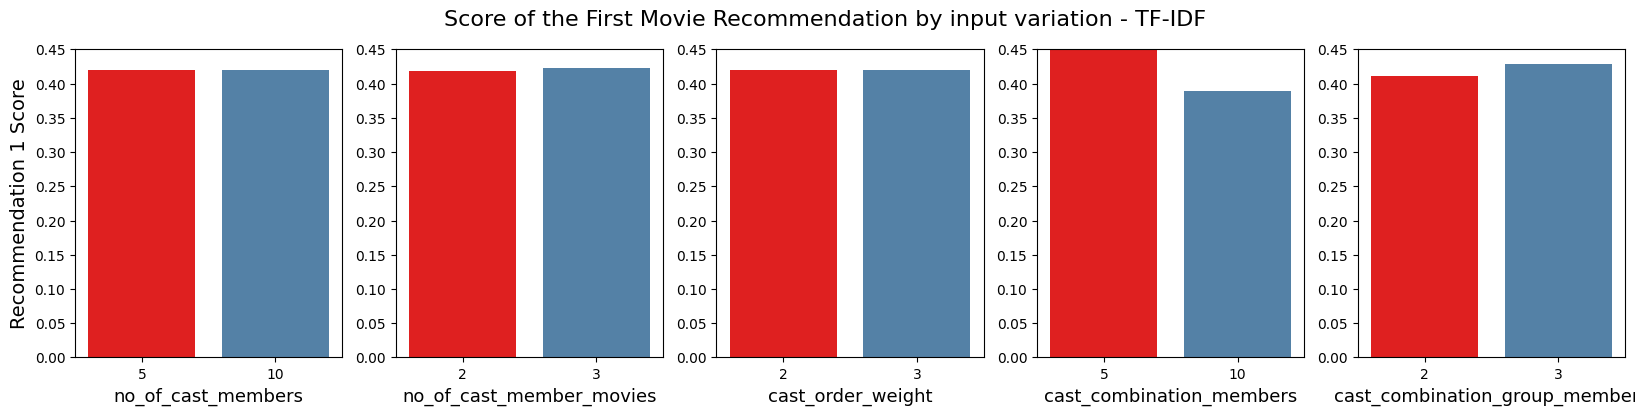

In [ ]:
simulation_plot(columns_plot, 'tf-idf', results_df)

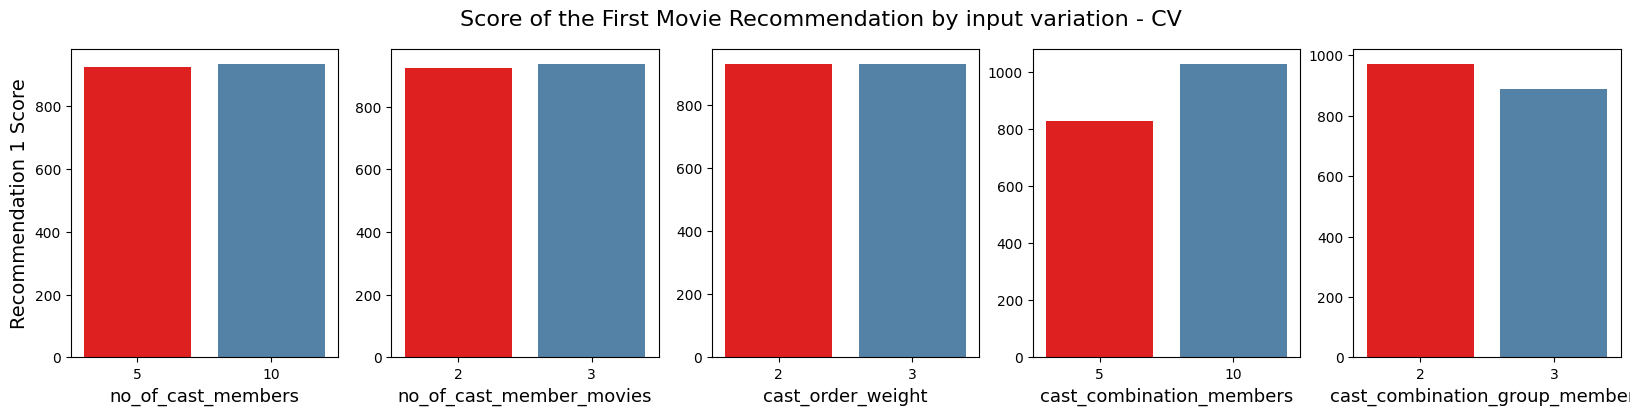

In [ ]:
simulation_plot(columns_plot, 'cv', results_df)

#### Conclusions:
- Analyzing the metrics is challenging because the scores are based on raw word counts. Adding more information only increases the total count, which doesn’t necessarily improve the results.

#### Count Vectorizer vs TF-IDF

Count Vectorizer (CV) helps analyze the dataset by showing how often words appear. However, it has some key limitations:

It treats all word occurrences equally, meaning that frequently used words are considered more important, regardless of context or relevance.

It doesn’t capture any relationship or semantic meaning between words.

TF-IDF (Term Frequency - Inverse Document Frequency) also measures word importance, but does so more intelligently. Instead of just counting, it reduces the weight of extremely common or rare words, helping to highlight the terms that are truly meaningful across the corpus. This leads to a more focused feature set and better computational efficiency.

#### For these reasons, we’ve decided to proceed with TF-IDF.

In [ ]:
# Get the title of the most voted movies
most_voted_titles = pd.merge(most_voted_movies,
                             df_movie_info_simulation[['movieId', 'title']],
                             on='movieId')

In [ ]:
features = ['no_of_cast_members', 'no_of_cast_member_movies', 'cast_order_weight',
           'cast_combination_members', 'cast_combination_group_members']

scores_fields = [('rec_' + str(n) + '_score') for n in range(1,6)]

new_df_lst = []

for sco in scores_fields:
    temp_df = results_df[(results_df['target_title'].isin(most_voted_titles['title'])) &
                        (results_df['algo'] == 'tf-idf')]
    temp_df = temp_df[features + [sco]]
    temp_df = temp_df.rename(columns={sco:'score'})
    temp_df['rank'] = sco
    new_df_lst.append(temp_df)

new_df = pd.concat(new_df_lst)
new_df = new_df.reset_index(drop=True)

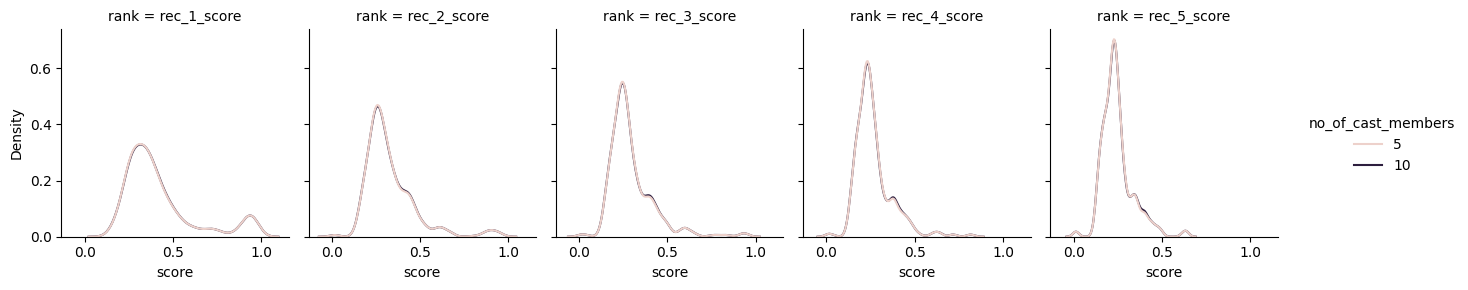

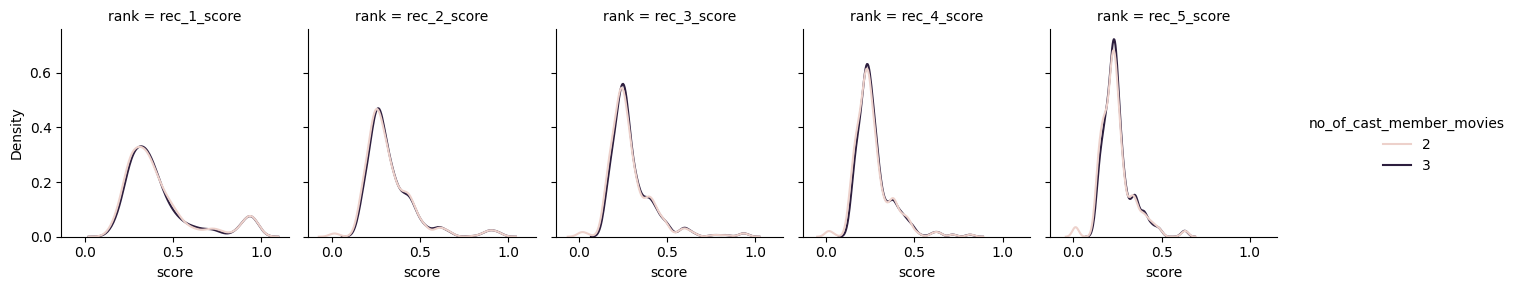

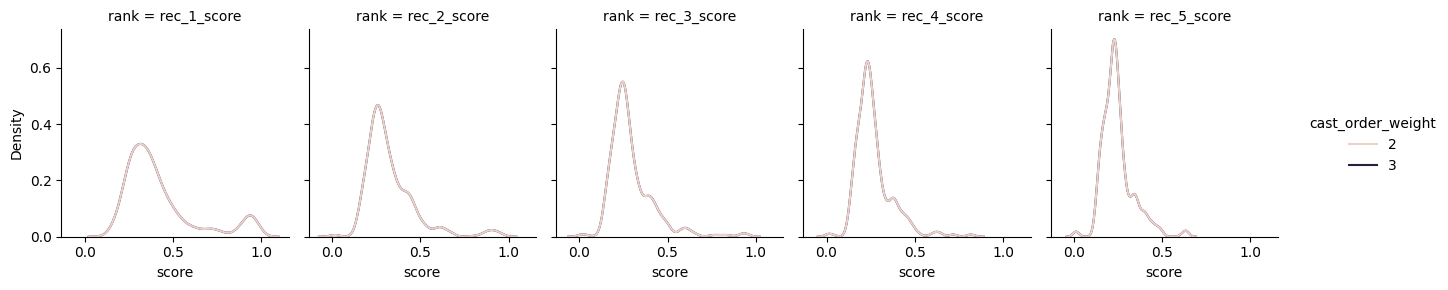

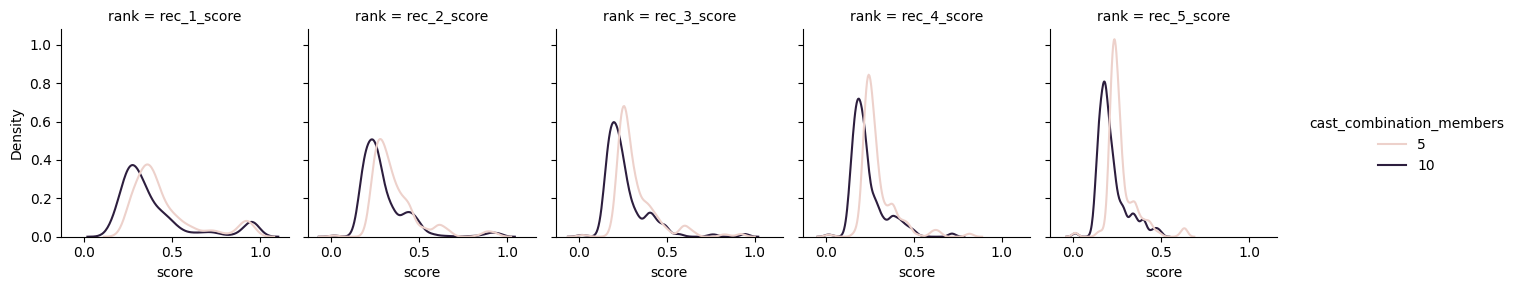

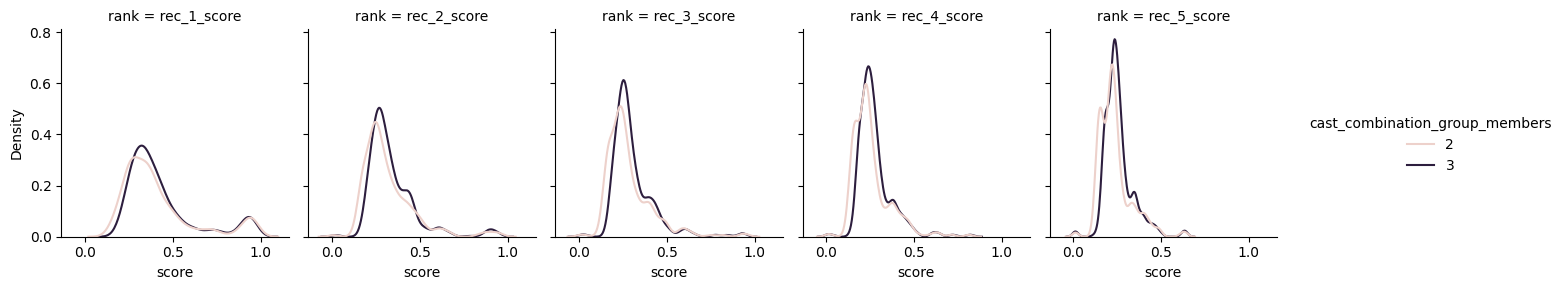

In [ ]:
for feat in features:
    sns.displot(x='score',
                hue=feat,
                data=new_df,
                col='rank',
                kind='kde',
                height=3,
                aspect=7/8)

    plt.show();

Rather than relying on visual analysis through charts, we will calculate statistical metrics for the first recommendation across all combinations of input features.

In [ ]:
metrics_results = []

for no_of_cast_members in [5, 10]:
    for no_of_cast_member_movies in [2, 3]:
        for cast_order_weight in [2,3]:
            for cast_combination_members in [5, 10]:
                for cast_combination_group_members in [2, 3]:
                    filtered_df = results_df[(results_df['algo'] == 'tf-idf') &
                       (results_df['no_of_cast_members'] == no_of_cast_members) &
                       (results_df['no_of_cast_member_movies'] == no_of_cast_member_movies) &
                       (results_df['cast_order_weight'] == cast_order_weight) &
                       (results_df['cast_combination_members'] == cast_combination_members) &
                       (results_df['cast_combination_group_members'] == cast_combination_group_members)]

                    filtered_df = filtered_df[['rec_1_score', 'rec_2_score', 'rec_3_score']].describe()
                    filtered_df = filtered_df.transpose()

                    filtered_df['no_of_cast_members'] = no_of_cast_members
                    filtered_df['no_of_cast_member_movies'] = no_of_cast_member_movies
                    filtered_df['cast_order_weight'] = cast_order_weight
                    filtered_df['cast_combination_members'] = cast_combination_members
                    filtered_df['cast_combination_group_members'] = cast_combination_group_members

                    metrics_results.append(filtered_df)

In [ ]:
metrics_df = pd.concat(metrics_results).reset_index()

# Ordering by the median - rec_1_score
metrics_df = metrics_df.rename(columns={'index': 'rank'})
metrics_df[metrics_df['rank'] == 'rec_1_score'].sort_values('50%', ascending=False).head()

,rank,count,mean,std,min,25%,50%,75%,max,no_of_cast_members,no_of_cast_member_movies,cast_order_weight,cast_combination_members,cast_combination_group_members
39,rec_1_score,232.0,0.456379,0.186194,0.24,0.3375,0.4,0.5,0.97,5,3,3,5,3
87,rec_1_score,232.0,0.456767,0.186058,0.24,0.3375,0.4,0.5,0.97,10,3,3,5,3
75,rec_1_score,232.0,0.456767,0.186058,0.24,0.3375,0.4,0.5,0.97,10,3,2,5,3
15,rec_1_score,241.0,0.455934,0.186590,0.24,0.3400,0.4,0.5,0.97,5,2,3,5,3
63,rec_1_score,241.0,0.456307,0.186461,0.24,0.3400,0.4,0.5,0.97,10,2,3,5,3


In [ ]:
# rec_2_score
metrics_df[metrics_df['rank'] == 'rec_2_score'].sort_values('50%', ascending=False).head()

,rank,count,mean,std,min,25%,50%,75%,max,no_of_cast_members,no_of_cast_member_movies,cast_order_weight,cast_combination_members,cast_combination_group_members
40,rec_2_score,232.0,0.369052,0.136451,0.23,0.28,0.33,0.41,0.93,5,3,3,5,3
88,rec_2_score,232.0,0.369483,0.136495,0.23,0.28,0.33,0.41,0.93,10,3,3,5,3
76,rec_2_score,232.0,0.369483,0.136495,0.23,0.28,0.33,0.41,0.93,10,3,2,5,3
28,rec_2_score,232.0,0.369052,0.136451,0.23,0.28,0.33,0.41,0.93,5,3,2,5,3
16,rec_2_score,241.0,0.364606,0.138699,0.02,0.28,0.32,0.41,0.93,5,2,3,5,3


In [ ]:
# rec_3_score
metrics_df[metrics_df['rank'] == 'rec_3_score'].sort_values('50%', ascending=False).head()

,rank,count,mean,std,min,25%,50%,75%,max,no_of_cast_members,no_of_cast_member_movies,cast_order_weight,cast_combination_members,cast_combination_group_members
41,rec_3_score,232.0,0.333147,0.118259,0.20,0.26,0.29,0.37,0.92,5,3,3,5,3
89,rec_3_score,232.0,0.333534,0.118419,0.20,0.26,0.29,0.37,0.92,10,3,3,5,3
77,rec_3_score,232.0,0.333534,0.118419,0.20,0.26,0.29,0.37,0.92,10,3,2,5,3
17,rec_3_score,241.0,0.327510,0.122217,0.02,0.26,0.29,0.36,0.92,5,2,3,5,3
65,rec_3_score,241.0,0.327842,0.122387,0.02,0.26,0.29,0.37,0.92,10,2,3,5,3


In [ ]:
# Get recommendations for the chosen inputs
recommendations = simulation(no_of_cast_members=5,
                             no_of_cast_member_movies=3,
                             cast_order_weight=2,
                             cast_combination_members=5,
                             cast_combination_group_members=3)

In [ ]:
recommendations[recommendations['algo'] == 'tf-idf'][['target_title',
                                                      'rec_1_title', 'rec_1_score',
                                                      'rec_2_title', 'rec_2_score',
                                                      'rec_3_title', 'rec_3_score',
                                                      'rec_4_title', 'rec_4_score',
                                                      'rec_5_title', 'rec_5_score']].sort_values('target_title')\
                                                               .set_index('target_title')

,rec_1_title,rec_1_score,rec_2_title,rec_2_score,rec_3_title,rec_3_score,rec_4_title,rec_4_score,rec_5_title,rec_5_score
target_title,,,,,,,,,,
"Dark Knight, The","Dark Knight Rises, The",0.41,Batman Begins,0.39,"Flowers of War, The (Jin líng shí san chai)",0.38,"Prestige, The",0.35,In the Company of Men,0.34
Fight Club,"Painted Veil, The",0.33,Moonrise Kingdom,0.31,War Machine,0.25,Formula 51,0.24,"Incredible Hulk, The",0.23
Forrest Gump,Return with Honor,0.40,Apollo 13,0.36,Bachelor Party,0.35,"Polar Express, The",0.25,The Purge: Election Year,0.25
"Godfather, The",Serpico,0.46,Guys and Dolls,0.32,"Teahouse of the August Moon, The",0.32,The Wild One,0.31,One-Eyed Jacks,0.31
"Matrix, The","Matrix Revolutions, The",0.96,"Matrix Reloaded, The",0.91,"Animatrix, The",0.57,Memento,0.45,Frankenstein,0.44
Pulp Fiction,I Am Not Your Negro,0.47,African Cats,0.44,Basic,0.44,Unbreakable,0.41,Die Hard: With a Vengeance,0.39
"Shawshank Redemption, The",Catch a Fire,0.28,John Dies at the End,0.28,Tenacious D in The Pick of Destiny,0.27,LEGO Batman: The Movie - DC Heroes Unite,0.26,Code 46,0.23
Toy Story,Toy Story 3,0.42,Toy Story 2,0.41,Return with Honor,0.37,Bachelor Party,0.34,Ernest Saves Christmas,0.29
"Usual Suspects, The",End of Days,0.36,One Tough Cop,0.26,Threesome,0.26,"Flintstones in Viva Rock Vegas, The",0.26,P.S.,0.25


We will likely need to take the score values into account and set a threshold, as some recommendations have significantly lower scores than others. However, we’re not addressing that at this stage. We will revisit this analysis once the final or hybrid model is in place.

#### Final content-based model
Instead of using the previous model, we’ll build a new one specifically designed for integration into the hybrid model. This version will use only TF-IDF and produce output in a revised format.

In [ ]:
def content_based_model(no_of_cast_members,
                        no_of_cast_member_movies,
                        cast_order_weight,
                        cast_combination_members,
                        cast_combination_group_members,
                        df_movie_info_simulation=df_movie_info_simulation,
                        df_movie_cast_simulation=df_movie_cast_simulation):

    # Keep only cast members in more than one movie
    cast_count = df_movie_cast_simulation.groupby('cast_name').count()['movieId'].reset_index()
    cast_count.columns = ['cast_name', 'count']
    cast_name_filtered = list(cast_count[cast_count['count'] > no_of_cast_member_movies]['cast_name'])
    cast_name_filtered = set(cast_name_filtered)
    df_filtered_cast = df_movie_cast_simulation[df_movie_cast_simulation['cast_name'].isin(cast_name_filtered)]

    # Create a new column with new order
    df_filtered_cast['new_order'] = df_filtered_cast.groupby('movieId').rank()['cast_order']

    # After reviewing different casts we are going to keep the first no_of_cast_members cast members
    # We found that to be a good number
    df_filtered_cast = df_filtered_cast[df_filtered_cast['new_order'] < no_of_cast_members]

    # Define multiplier weight value
    cast_order_multiplier_value = no_of_cast_members // cast_order_weight

    # Create Multiplier to give top cast members more weight
    df_filtered_cast['multiplier'] = cast_order_multiplier_value - \
                                    (df_filtered_cast['new_order'] // cast_order_weight)
    df_filtered_cast['clean_cast_name'] = df_filtered_cast['cast_name'].str.lower().str.replace(' ', '')
    df_filtered_cast['weighted_cast'] = df_filtered_cast.apply(lambda x: (x['clean_cast_name'] + ' ')
                                                               * int(x['multiplier'])
                                                               , axis=1)

    # Come up with cast combinations
    df_movie_cast_combinations = df_filtered_cast.groupby('movieId')\
                                                 .apply(lambda x: cast_combinations(x,
                                                                                    cast_combination_members,
                                                                                    cast_combination_group_members))
    df_movie_cast_combinations = df_movie_cast_combinations.reset_index()
    df_movie_cast_combinations.columns = ['movieId', 'cast_combinations']

    # Create a column with weighted cast
    df_movie_cast_modified = df_filtered_cast.groupby('movieId')['weighted_cast']\
                                             .apply(lambda x: ' '.join(x))\
                                             .reset_index()

    df_movie_cast_modified = pd.merge(df_movie_info_simulation.drop('weighted_cast', axis=1),
                                      df_movie_cast_modified, on='movieId')


    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['weighted_cast'] + ' ' +
                                                        df_movie_info_title['title'] + ' ' +
                                                        df_movie_info_title['description'] + ' ' +
                                                        df_movie_info_title['movie_plot'] + ' ' +
                                                        df_movie_info_title['keywords'])

    df_movie_info_simulation = pd.merge(df_movie_info_simulation.drop('cast_combinations', axis=1),
                                        df_movie_cast_combinations[['movieId', 'cast_combinations']],
                                        on='movieId')

    df_movie_info_simulation['all_content_features'] = (df_movie_info_simulation['all_content_features'] + ' ' +
                                                        df_movie_info_simulation['cast_combinations'])

    # Fit the model - TF-IDF and CountVectorizer
    tf = TfidfVectorizer(analyzer='word',
                         ngram_range=(1, 2),
                         min_df=1,
                         stop_words='english')

    tfidf_matrix = tf.fit_transform(df_movie_info_simulation['all_content_features'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    df_cosine_sim = pd.DataFrame(cosine_sim)
    df_cosine_sim.columns = df_movie_info_simulation['movieId'].to_list()
    df_cosine_sim = pd.merge(df_cosine_sim,
                              df_movie_info_simulation[['movieId']],
                              right_index=True,
                              left_index=True)

    return df_cosine_sim

In [ ]:
def get_recommendations_content(title, df_cosine_sim, df_movie_info_simulation):
    # Grab the movieId from dataframe
    target_movieId = df_movie_info_simulation.loc[df_movie_info_simulation['title'] == title]['movieId']
    target_movieId = target_movieId.values[0]

    # Extract scores and sort them
    if target_movieId in df_cosine_sim['movieId'].to_list():
        target_row = df_cosine_sim[df_cosine_sim['movieId'] == target_movieId]
        target_row = target_row.transpose().reset_index().iloc[:-1]
        target_row.columns = ['movieId', 'score']
        target_row = target_row.sort_values('score', ascending=False).iloc[1:]

        # Keep only top 5 recommendations and return that
        df_reco = target_row[target_row['score'] > 0].iloc[:5].reset_index(drop=True)

        # Create dataframe with recommendations
        df_reco['movie_target_name'] = title
        df_reco['movie_target_movieId'] = target_movieId
        df_reco = df_reco.reset_index()
        df_reco = df_reco.rename(columns={'index': 'rec_n'})

        return df_reco

In [ ]:
# Extract trained model
content_model = content_based_model(no_of_cast_members=5,
                                    no_of_cast_member_movies=3,
                                    cast_order_weight=2,
                                    cast_combination_members=5,
                                    cast_combination_group_members=3)

In [ ]:
# Test the output
get_recommendations_content('Toy Story', content_model, df_movie_info_simulation)

,rec_n,movieId,score,movie_target_name,movie_target_movieId
0,0,78499,0.419362,Toy Story,1
1,1,3114,0.408830,Toy Story,1
2,2,2930,0.370685,Toy Story,1
3,3,3525,0.337040,Toy Story,1
4,4,4502,0.293356,Toy Story,1




## Collaborative-Based Filtering <a class="anchor" id="colab"></a>

Collaborative Filtering is built on the idea that users with similar preferences to mine can help predict how much we might like a product or service they’ve experienced but we haven’t.

Our approach is to test multiple models and compare their performance, with RMSE as the primary evaluation metric. While models like Singular Value Decomposition (SVD) or SVD++ are often top performers according to existing literature, it’s still valuable to explore other options instead of relying solely on these.

Additionally, we’re factoring in model training time, as a model that performs well but takes too long to train may not be practical for deployment.

In [ ]:
# Create a new dataframe to train the model.
df_ratings_clean = df_ratings[['userId', 'movieId', 'rating']]

#### Reduce dataset to decrease runtime
To make the process more efficient, we’re using only 50% of the data to tune the hyperparameters for the SVD model. From that subset, we’ll run GridSearchCV on just half. Once the optimal hyperparameters are identified, we’ll retrain the model on the full dataset.

In [ ]:
# Randomly pick 50,000 datapoints fmor the dataset
sample_df = df_ratings_clean.sample(n=50000, random_state=111)

# Split the sample data in two so I can test the best hyperparameters later on
train_df, test_df = train_test_split(sample_df, train_size=.50, random_state=111)

# Create reader and dataset objects
reader = Reader()
traindata = Dataset.load_from_df(train_df, reader)
testdata = Dataset.load_from_df(test_df, reader)

### GridSearchCV - Hyperparameter Tunning of SVD <a class="anchor" id="grid"></a>


In [ ]:
# Perform a gridsearch with SVD
param_grid = {'n_factors':[10, 15, 20]
              , 'n_epochs': [10, 20]
              , 'lr_all': [0.008, 0.012]
              , 'reg_all': [0.06, 0.1]
              , 'random_state': [111]}

gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, joblib_verbose=False)

%time gs_model.fit(traindata)

CPU times: user 3.97 s, sys: 80.8 ms, total: 4.05 s
Wall time: 17.7 s


In [ ]:
print('The best parameters are:')
gs_model.best_params['rmse']

The best parameters are:


{'n_factors': 10,
 'n_epochs': 20,
 'lr_all': 0.008,
 'reg_all': 0.1,
 'random_state': 111}

### GridSearchCV Metrics Analysis
Let’s evaluate the metrics from each run and select the best hyperparameters based on both RMSE and fit time. While GridSearchCV is designed to minimize RMSE, choosing the lowest RMSE alone may not be ideal—especially if the model takes too long to train. Since we plan to deploy this model as an online service, fit time is a critical factor to consider alongside accuracy.

In [ ]:
# Convert results from the GridSearchCV to dataframes
df_params = pd.DataFrame(gs_model.cv_results['params'])
df_rmse = pd.DataFrame(gs_model.cv_results['mean_test_rmse'], columns=['mean_test_rmse'])
df_time = pd.DataFrame(gs_model.cv_results['mean_fit_time'], columns=['mean_fit_time'])
df_results = pd.concat([df_params, df_rmse, df_time], axis=1)

Function to print metrics so we can see the impact of hyperparameters in RMSE and Fit Time.

In [ ]:
def compare_metrics_chart(df, column_a, column_b):
    """
    Function to plot the comparison of two metrics in a GridSearchCV run.

    Args:
        df(pd.Dataframe): Pandas Dataframe with GridSearchCV metrics.
        column_a(str): First metric
        column_b(str): Second Metric
    """
    # Create Figure
    fig = plt.figure(figsize=(10,5))

    # Create first axis
    ax = fig.add_subplot(111)
    # Plot Column A
    sns.lineplot(data=df[column_a], color="g", ax=ax)
    # Set Y Label
    ax.set_ylabel(column_a, color='g', size=10)

    # Create axis 2
    ax2 = plt.twinx()
    # Plot Column B
    sns.lineplot(data=df[column_b], color="b", ax=ax2)
    # Set Y Label
    ax2.set_ylabel(column_b, color='b', size=10)

    # Change the format of the title
    column_a_title = column_a.replace('_', ' ').title()
    column_b_title = column_b.replace('_', ' ').title()
    plt.title(column_a_title + ' vs. ' + column_b_title)

    plt.show();

#### Number of Factors

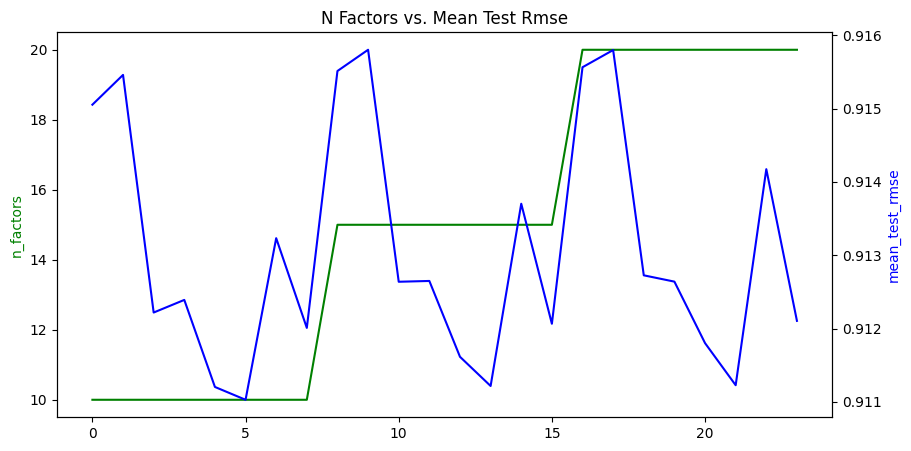

In [ ]:
compare_metrics_chart(df_results, 'n_factors', 'mean_test_rmse')

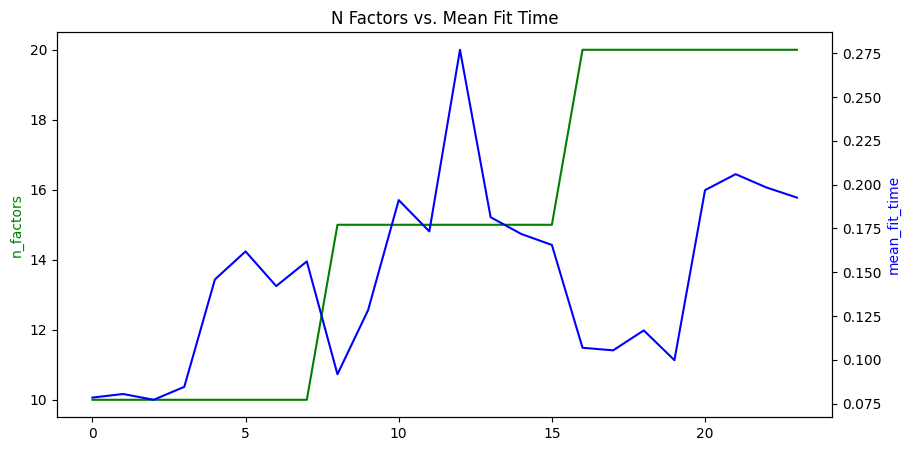

In [ ]:
compare_metrics_chart(df_results, 'n_factors', 'mean_fit_time')

The lowest RMSE values are achieved regardless of the number of factors. While it’s generally expected that increasing the number of factors would lead to lower RMSE, this comes at the expense of longer fit times. Given that the data shows we can achieve comparable low RMSE with just 10 factors, we’ll go with that option to balance performance and efficiency.

#### Number of Epochs

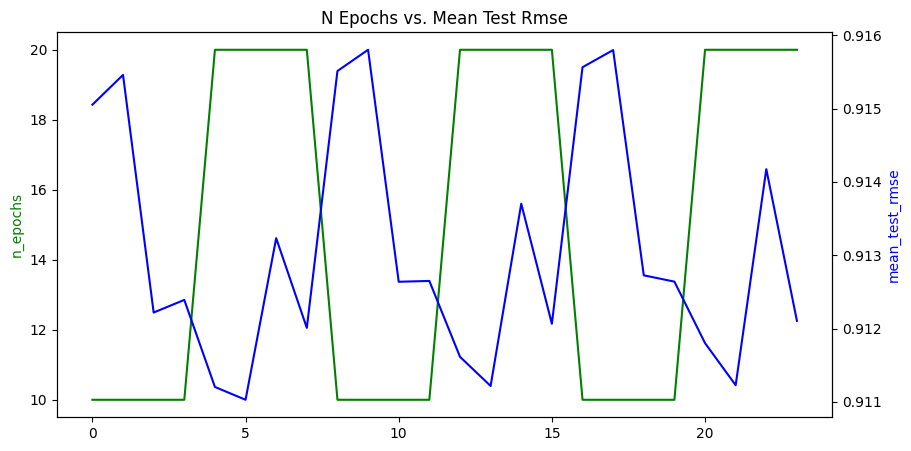

In [ ]:
compare_metrics_chart(df_results, 'n_epochs', 'mean_test_rmse')

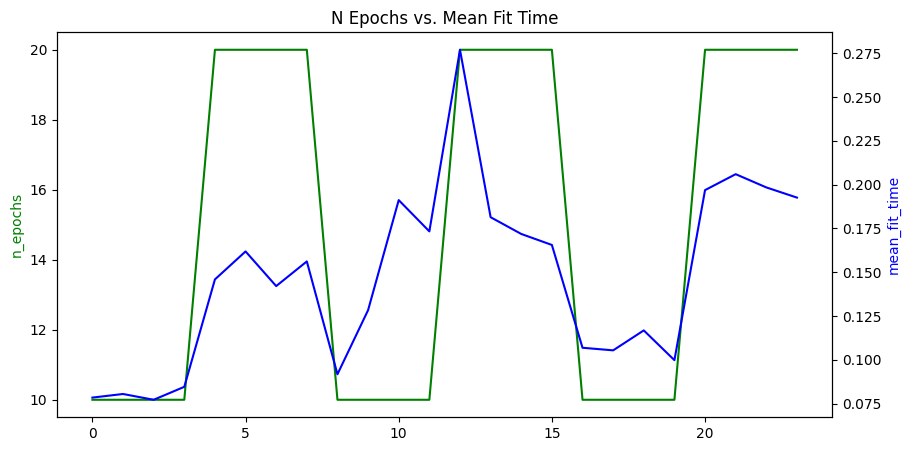

In [ ]:
compare_metrics_chart(df_results, 'n_epochs', 'mean_fit_time')

Increasing the number of epochs does reduce RMSE, but it also leads to a 50–80% increase in fit time—an overhead that outweighs the marginal gains in accuracy. Therefore, we have decided to proceed with `20` epochs as a more balanced choice.

#### Regularization Term

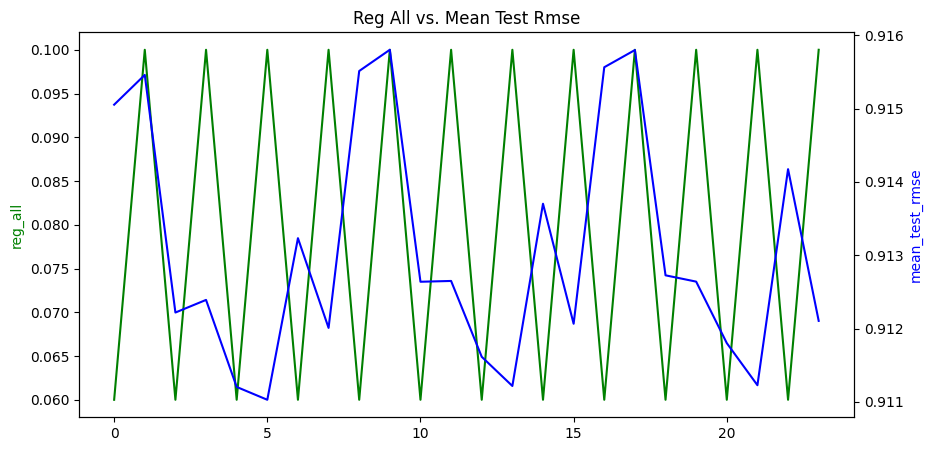

In [ ]:
compare_metrics_chart(df_results, 'reg_all', 'mean_test_rmse')

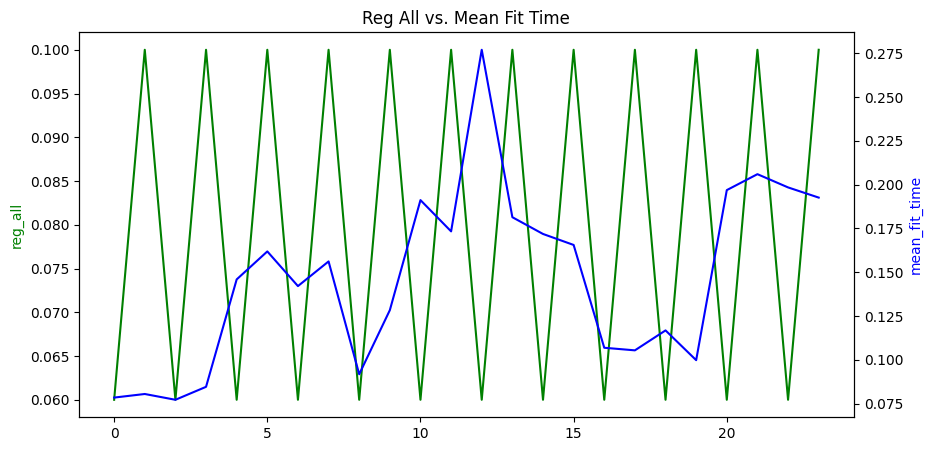

In [ ]:
compare_metrics_chart(df_results, 'reg_all', 'mean_fit_time')



#### Learning Rate

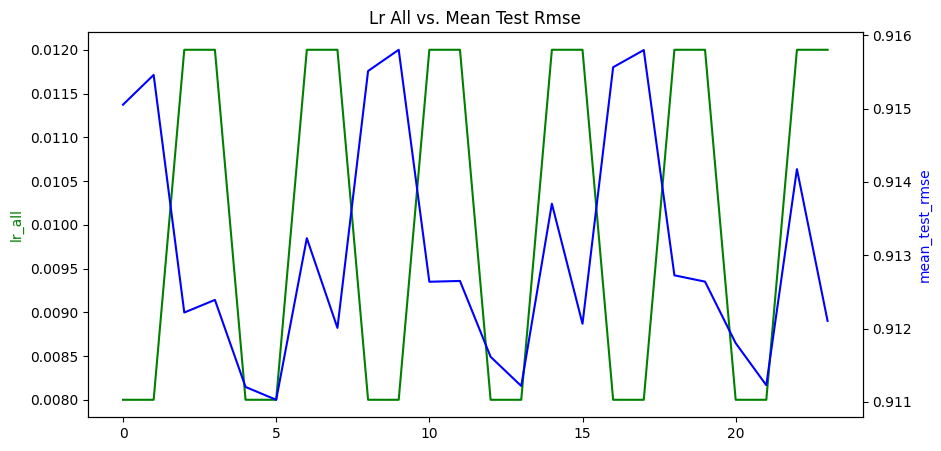

In [ ]:
compare_metrics_chart(df_results, 'lr_all', 'mean_test_rmse')

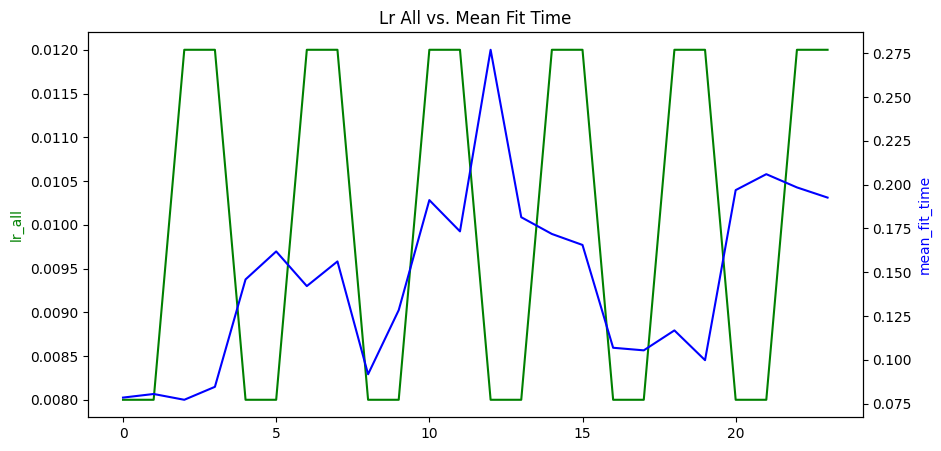

In [ ]:
compare_metrics_chart(df_results, 'lr_all', 'mean_fit_time')



### Different models <a class="anchor" id="dif"></a>
#### Create a function to easily test different models

In [ ]:
def full_model_training_evaluation(model, model_name, traindata, testdata):
    """
    Train and test different models and collect fit time and train/test RMSE.

    Args:
        model(surprise.prediction_algorithms): Model instances from the surprise package.
        model_name(str): Model name created by the User. A way to identify the model.
        traindata(surprise.dataset.DatasetAutoFolds): Train dataset
        testdata(surprise.dataset.DatasetAutoFolds): Test dataset

    Returns:
        results(dict): A dictionary with the model name, fit time and RMSE's (train/test).
    """
    # Stor results in dictionary
    results = {}
    results['model_name'] = model_name
    print('Training', model_name, 'model')

    # Fit on train data
    start_time = time.time()
    model.fit(traindata.build_full_trainset())
    end_time = time.time()
    total_time = round(end_time - start_time, 2)
    results['fit_time_in_seconds'] = total_time

    # Get RMSE on train data
    predictions_train = model.test(traindata.build_full_trainset().build_testset())
    rmse_train = rmse(predictions_train, verbose=False).round(2)
    results['rmse_train'] = rmse_train

    # Get RMSE on test data
    predictions_test = model.test(testdata.build_full_trainset().build_testset())
    rmse_test = rmse(predictions_test, verbose=False).round(2)
    results['rmse_test'] = rmse_test

    return results

Instantiate different models

In [ ]:
# Create SVD model with the best hyperparameters
svd = SVD(n_factors=15, n_epochs=20, lr_all=0.012, reg_all=0.06, random_state=111)

In [ ]:
# SVD++: Use the same hyperparameters
svd_pp = SVDpp(n_factors=15, n_epochs=20, lr_all=0.012, reg_all=0.06, random_state=111)

In [ ]:
# Different instances of KNN Basic models with different hyperparameters
knn_basic_person_baseline = KNNBasic(sim_options={'name':'pearson_baseline', 'user_based':True}, verbose=False)
knn_basic_person = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=False)
knn_basic_cosine = KNNBasic(sim_options={'name':'cosine', 'user_based':True}, verbose=False)

In [ ]:
# Different instances of KNN Baseline models with different hyperparameters
knn_base_person_baseline = KNNBaseline(sim_options={'name':'pearson_baseline', 'user_based':True}, verbose=False)
knn_base_person = KNNBaseline(sim_options={'name':'pearson', 'user_based':True}, verbose=False)
knn_base_cosine = KNNBaseline(sim_options={'name':'cosine', 'user_based':True}, verbose=False)

In [ ]:
# Put all models in a dictionary
models = {'SVD': svd,
          'SVD++': svd_pp,
          'KNNBasic Cosine': knn_basic_cosine,
          'KNNBasic Person': knn_basic_person,
          'KNNBasic Person Baseline': knn_basic_person_baseline,
          'KNNBaseline Cosine': knn_base_cosine,
          'KNNBaseline Person': knn_base_person,
          'KNNBaseline Person Baseline': knn_base_person_baseline}

In [ ]:
# Loop through different models and evaluate them
model_results = []

for model_name, model_instance in models.items():
    results = full_model_training_evaluation(model_instance, model_name, traindata, testdata)
    model_results.append(results)

Training SVD model
Training SVD++ model
Training KNNBasic Cosine model
Training KNNBasic Person model
Training KNNBasic Person Baseline model
Training KNNBaseline Cosine model
Training KNNBaseline Person model
Training KNNBaseline Person Baseline model




### Model Evaluation <a class="anchor" id="eval"></a>

In [ ]:
pd.DataFrame(model_results)

,model_name,fit_time_in_seconds,rmse_train,rmse_test
0,SVD,0.36,0.70,0.90
1,SVD++,6.35,0.65,0.90
2,KNNBasic Cosine,0.42,0.80,1.04
3,KNNBasic Person,0.05,0.54,1.08
4,KNNBasic Person Baseline,0.13,0.09,1.09
5,KNNBaseline Cosine,0.12,0.73,0.94
6,KNNBaseline Person,0.13,0.47,0.97
7,KNNBaseline Person Baseline,0.12,0.08,0.98


#### Notes:
- **Fit Time**:
 `SVD++`stands out as the slowest model by a significant margin. All KNN-based models have similar fit times, roughly 4 times faster than SVD. However, even SVD is considerably faster than  `SVD++`, making the latter impractical for deployment.

- **RMSE Train**:
The KNN models using user-based baseline (`person_baseline`) show signs of overfitting on the training set. Between the two `SVD` models,  `SVD++` achieves slightly better training RMSE than `SVD`.

- **RMSE Test**:
On the test set, both `SVD` and `SVD++` perform equally well and outperform all KNN models.

### Conclusion
Given the balance between performance and efficiency, I'll proceed with the `SVD` model. It offers competitive RMSE scores with a significantly faster fit time compared to `SVD++`, making it a more practical choice for real-world use.

## Function to take user input and give recommendations  <a class="anchor" id="func"></a>
Finally, we’ll implement a function that generates recommendations for a new user who has no prior ratings in the dataset. This function will take a selected genre and user-provided ratings as input. The recommendation process will be guided primarily by the chosen genre, leveraging the content-based aspect of the hybrid recommendation system.

In [ ]:
# Create list of genres
list_of_genres = stacked_genres['genre'].sort_values().unique()[1:]

In [ ]:
# Combine mean ratings and movies details
ratings_movies_df = pd.merge(mean_ratings_df, df_movies, on='movieId')

#### Removing movies with not enough ratings

In [ ]:
def filtered_dataset(genre):
    """
    Function to filter the dataset given the genre and remove outliers.

    Args:
        genre(str): The genre the user has chosen to come with recommendations.

    Returns:
        genre_df(pd.DataFrame): Filtered Dataframe with only the chosen genre.
    """
    # Keep only the selected genre
    genre_df = ratings_movies_df[ratings_movies_df['genres'].str.contains(genre)]

    # Calculate the 95th quantile and the weighted rating
    minimum_no_of_ratings = genre_df['count_rating'].quantile(0.95)
    genre_df['minimum_no_of_ratings'] = minimum_no_of_ratings
    genre_df['weighted_rating'] = genre_df.apply(weighted_rating, axis=1)

    # Remove movies with not enough ratings
    genre_df = genre_df[genre_df['count_rating'] >= minimum_no_of_ratings]

    # Sorted it by weighted rating so we have the highest ratings on the top
    genre_df = genre_df.sort_values('weighted_rating', ascending=False)
    genre_df = genre_df.reset_index(drop=True)

    # Keep certain relevant columns
    genre_df = genre_df[['movieId', 'title',
                         'genres', 'count_rating',
                         'minimum_no_of_ratings', 'weighted_rating']]

    return genre_df

#### Function to let the user rate five movies

In [ ]:
def rate_movie(n_of_movies=5, default_user_id=9999999):
    """
    Function to request a new user to review some movies.

    Args:
        n_of_movies(int): Number of ratings the new will have to give.
        default_user_id(int): Random user id that will be given to the user to be able to reference to it later.

    Returns:
        new_ratings_df(pd.DataFrame): Pandas Dataframe with the new ratings
        favorite_genre(str): The User's favorite genre
    """
    # Print a list of the available genres
    print('List of Available Genres: ', ", ".join(list_of_genres))

    # Gather input from user on which genre will be analyzed
    favorite_genre = input('Choose one genre from the following (case-sensitive): ')

    # Filter the dataset
    df_movies_popularity = filtered_dataset(favorite_genre)

    # Keep only movies that contain the chosen genre
    favorite_genre_movies = df_movies_popularity[df_movies_popularity['genres'].str.contains(favorite_genre)]

    # Keep the highest rated movies
    favorite_genre_movies = favorite_genre_movies.iloc[:20].sample(frac=1, random_state=111)
    favorite_genre_movies = favorite_genre_movies.iloc[:n_of_movies]
    print('')

    # Created to store ratings from user
    ratings_list = []

    # Loop through dataframe with movies to be rated
    for row in favorite_genre_movies.iterrows():
        # Extract Title and ID
        movie_title = row[1]['title']
        movie_id = row[1]['movieId']

        print('Movie to rate: ', movie_title)

        # Gather rating from user
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')

        # Deal with users not typing a number and create a new variable with the integer
        try:
            rating_int = int(rating)
        except:
            rating_int = 1

        # While the Rating is not valid, keep asking the user
        while (rating != 'n') and not (1 <= rating_int <=5):
            rating = input('Please rate the movie between 1-5 or n if you have not seen : \n')
        else:
            # If the rating is different from 'n' then we need to add the rating to the list
            if rating != 'n':
                ratings_list.append({'userId': default_user_id,
                                    'movieId': movie_id,
                                    'rating': rating_int})
        print('')

    # Convert to DataFrame
    new_ratings_df = pd.DataFrame(ratings_list)

    return new_ratings_df, favorite_genre, df_movies_popularity

#### Function to give the recommendations

In [ ]:
def give_n_recommendations(model, default_user_id=9999999, n_recommendations=5):
    """
    Function to request a new user to review movies and give recommendations based on that.

    Args:
        model(surprise.prediction_algorithms): Model instances from the surprise package.
        default_user_id(int): Random user id that will be given to the user to be able to reference to it later.
        n_recommendations(int): Number of recommendations that will be given to the user.
    """
    # Extract ratings from the user
    new_ratings_df, favorite_genre, df_movies_popularity = rate_movie(default_user_id=default_user_id)
    watched_movies_id = new_ratings_df['movieId']

    # add the new ratings to the original ratings DataFrame
    updated_df = pd.concat([new_ratings_df, df_ratings_clean])
    new_data = Dataset.load_from_df(updated_df, reader)
    new_dataset = new_data.build_full_trainset()

    # Fit new dataset
    model.fit(new_dataset)

    # make predictions for the user
    results = []
    for movie_id in df_movies_popularity['movieId'].unique():
        predicted_score = model.predict(default_user_id, movie_id)[3]
        results.append((movie_id, predicted_score))

    # order the predictions from highest to lowest rated
    ranked_movies = pd.DataFrame(results, columns=['movieId', 'predicted_score'])
    ranked_movies = ranked_movies[~ranked_movies['movieId'].isin(watched_movies_id)]
    ranked_movies = ranked_movies.sort_values('predicted_score', ascending=False).reset_index(drop=True)
    ranked_movies = pd.merge(ranked_movies, df_movies, on='movieId')
    # ranked_movies = ranked_movies[ranked_movies['genres'].str.contains(favorite_genre)]

    print('The recommendations are the following:')
    if len(ranked_movies) < n_recommendations:
        n_recommendations = len(ranked_movies)
    for row in range(n_recommendations):
        movie_id = ranked_movies.iloc[row]['movieId']
        recommended_title = df_movies[df_movies['movieId'] == movie_id]['title'].item()
        print(f'Number {row+1} is {recommended_title}')

#### Test
We’ll test the model with different genres to observe how its recommendations vary and assess its behavior across various content preferences.

#### `Action`

In [ ]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
Choose one genre from the following (case-sensitive): Action

Movie to rate:  Star Wars: Episode V - The Empire Strikes Back (1980)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  Dark Knight, The (2008)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Inception (2010)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Apocalypse Now (1979)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3

Movie to rate:  Blade Runner (1982)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4

The recommendations are the following:
Number 1 is Fight Club (1999)
Number 2 is Matrix, The (1999)
Number 3 is Star Wars: Epis

#### `Romance`

In [ ]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
Choose one genre from the following (case-sensitive): Romance

Movie to rate:  Casablanca (1942)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  American Beauty (1999)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Shrek (2001)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Graduate, The (1967)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3

Movie to rate:  Lost in Translation (2003)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

The recommendations are the following:
Number 1 is Life Is Beautiful (La Vita è bella) (1997)
Number 2 is Eternal Sunshine of the Spotless Mind (2004)
Number 3 i

# Hybrid Model

In [ ]:
df_movie_info_title[df_movie_info_title['title'].astype(str).str.contains('Notebook')]

,movieId,weighted_cast,title_x,title_y,genres,year,keywords,description,movie_plot,title,cast_combinations
4622,8533,rachelmcadams rachelmcadams rachelmcadams rach...,"Notebook, The","Notebook, The (2004)",Drama|Romance,2004,poem river sadness fight love of one's life de...,An epic love story centered around an older ma...,"Notebook, The (2004) is a drama, romance film ...","Notebook, The",rachelmcadamsryangosling genarowlandsrachelmca...


In [ ]:
favorite_movies = ['Inception',
                   'Pulp Fiction']

# favorite_movies = ['Hidden Figures',
#                   'Moneyball',
#                   'Django Unchained',
#                   'Titanic',
#                   'Notebook, The',
#                   'The Hateful Eight',
#                   'Inglourious Basterds']

favorite_movieIds = df_movie_info_title[df_movie_info_title['title'].isin(favorite_movies)]['movieId']

In [ ]:
def collect_content_recommendations(favorite_movies=favorite_movies,
                                   content_model=content_model,
                                   df_movie_info_simulation=df_movie_info_simulation):

    # Run content related recommendations
    content_recos = []

    for fav in favorite_movies:
        content_recos.append(get_recommendations_content(fav, content_model, df_movie_info_simulation))

    # Create a dataframe of and bring the title
    content_recos_df = pd.concat(content_recos)
    content_recos_df = pd.merge(content_recos_df,
                                df_movie_info_title[['movieId', 'title']],
                                on='movieId')

    # Make sure we do not recommend one of the favorite movies
    content_recos_df = content_recos_df[(~content_recos_df['title'].isin(favorite_movies))]

    # Sort dataframe by 'score' and calculate the max score and the number of times the same movie was
    # recommended
    content_recos_df = content_recos_df.sort_values('score', ascending=False).reset_index(drop=True)
    count_of_times = content_recos_df.groupby('movieId').agg({'score': ['max','count']}).reset_index()
    count_of_times.columns = ['movieId', 'max_score', 'no_of_times']

    # Keep only one recommendation for the same movie
    content_recos_df = pd.merge(content_recos_df, count_of_times, on='movieId')
    content_recos_df = content_recos_df.drop_duplicates('movieId', keep='first')

    # Keep only max two recommendations for the same movie
    content_recos_df['rank'] = content_recos_df.groupby('movie_target_movieId').rank()['rec_n']

    return content_recos_df

In [ ]:
def collect_collaborative_recommendations(ratings_movies_df=ratings_movies_df,
                                          favorite_movieIds=favorite_movieIds,
                                          df_ratings_clean=df_ratings_clean,
                                          svd=svd,
                                          default_user_id = 9999999):

    # Create copy of the dataframe to work with
    genre_df = ratings_movies_df.copy()

    # Calculate the 80th quantile and the weighted rating
    minimum_no_of_ratings = genre_df['count_rating'].quantile(0.80)
    genre_df['minimum_no_of_ratings'] = minimum_no_of_ratings
    genre_df['weighted_rating'] = genre_df.apply(weighted_rating, axis=1)

    # Remove movies with not enough ratings
    genre_df = genre_df[genre_df['count_rating'] >= minimum_no_of_ratings]

    # Sorted it by weighted rating so we have the highest ratings on the top
    genre_df = genre_df.sort_values('weighted_rating', ascending=False)
    genre_df = genre_df.reset_index(drop=True)

    # Add ratings from the user (assume they ratings are all 5)
    ratings_list = []

    for watched in favorite_movieIds:
        ratings_list.append({'userId': default_user_id,
                             'movieId': watched,
                             'rating': 5})

    # Convert to DataFrame
    new_ratings_df = pd.DataFrame(ratings_list)

    # add the new ratings to the original ratings DataFrame
    updated_df = pd.concat([new_ratings_df, df_ratings_clean])
    new_data = Dataset.load_from_df(updated_df, reader)
    new_dataset = new_data.build_full_trainset()

    # Fit new dataset
    svd.fit(new_dataset)

    # make predictions for the user
    results = []
    for movie_id in genre_df['movieId'].unique():
        predicted_score = svd.predict(default_user_id, movie_id)[3]
        results.append((movie_id, predicted_score))

    # order the predictions from highest to lowest rated
    ranked_movies = pd.DataFrame(results, columns=['movieId', 'predicted_score'])
    ranked_movies = ranked_movies[~ranked_movies['movieId'].isin(new_ratings_df['movieId'])]
    ranked_movies = ranked_movies.sort_values('predicted_score', ascending=False).reset_index(drop=True)
    ranked_movies = pd.merge(ranked_movies, df_movies, on='movieId')

    return ranked_movies

In [ ]:
def hybrid_model(favorite_movies=favorite_movies,
                 content_model=content_model,
                 df_movie_info_simulation=df_movie_info_simulation,
                 ratings_movies_df=ratings_movies_df,
                 df_ratings_clean=df_ratings_clean,
                 svd=svd,
                 collaborative_weight=0.5,
                 content_weight=0.5):

    # Get recommendations from content-based model
    content_recos_df = collect_content_recommendations(favorite_movies,
                                                       content_model,
                                                       df_movie_info_simulation)

    # Get recommendations from collaborative-based model
    ranked_movies = collect_collaborative_recommendations(ratings_movies_df,
                                                          content_recos_df,
                                                          df_ratings_clean,
                                                          svd)

    # Combine dataframes
    combined_df = pd.merge(content_recos_df,
                           ranked_movies[['movieId', 'predicted_score']],
                           on='movieId')

    # Normalize collaborative score
    combined_df['norm_collaborative_score'] = np.log(combined_df['predicted_score'])

    # Scale collaborative score
    combined_df['scaled_collaborative_score'] = (
        (combined_df['norm_collaborative_score'] - combined_df['norm_collaborative_score'].min()) /
        (combined_df['norm_collaborative_score'].max() - combined_df['norm_collaborative_score'].min()))

    # Add more weight to movies that were recommended multiple times
    combined_df['no_of_times_score'] = combined_df['max_score'] * (1 + ((combined_df['no_of_times'] - 1) / 10))

    # Consider the rank of the recommendation to avoid recommending a bunch of movies for the same target
    combined_df['ranked_score'] = combined_df['no_of_times_score'] * (1 - ((combined_df['rank'] - 1) / 10))

    # Normalize content score
    combined_df['norm_content_score'] = np.log(combined_df['ranked_score'])

    # Scale the content score
    combined_df['scaled_content_score'] = (
        (combined_df['norm_content_score'] - combined_df['norm_content_score'].min()) /
        (combined_df['norm_content_score'].max() - combined_df['norm_content_score'].min()))

    # Combine both content + collaborative by giving 50% weight to each
    combined_df['final_score'] = ((collaborative_weight * combined_df['scaled_collaborative_score']) +
                                 (content_weight * combined_df['scaled_content_score']))

    # Sort values using that final score and keep only the top five
    combined_df = combined_df.sort_values('final_score', ascending=False).reset_index(drop=True)
    combined_df = combined_df[['movie_target_movieId', 'movie_target_name', 'movieId', 'title', 'final_score']]

    return combined_df

In [ ]:
def test_different_weights(favorite_movies):
    # Test different weights
    collaborative_weights = [i / 10 for i in range(1, 10)][::-1]
    content_weights = [i / 10 for i in range(1, 10)]

    hybrid_model_results = []

    for idx in range(9):
        results_hybrid = hybrid_model(favorite_movies=favorite_movies,
                                        content_model=content_model,
                                        df_movie_info_simulation=df_movie_info_simulation,
                                        ratings_movies_df=ratings_movies_df,
                                        df_ratings_clean=df_ratings_clean,
                                        svd=svd,
                                        collaborative_weight=collaborative_weights[idx],
                                        content_weight=content_weights[idx])

        results_hybrid['collaborative_weight'] = collaborative_weights[idx]
        results_hybrid['content_weight'] = content_weights[idx]

        hybrid_model_results.append(results_hybrid)

        hybrid_results_df = pd.concat(hybrid_model_results)
    hybrid_results_df = hybrid_results_df.reset_index()
    hybrid_results_df = hybrid_results_df.rename(columns={'index': 'rank'})

    return hybrid_results_df.pivot_table(values='title',
                                          index='rank',
                                          columns='content_weight',
                                         aggfunc='first').head(5)

Next, we’ll evaluate the recommendations using various IMDb movie lists I’ve found. This should provide a practical way to test the model on real-world data and see how well it generalizes beyond our dataset.

In [ ]:
# https://www.imdb.com/list/ls033375164/
test_different_weights(['Shawshank Redemption, The',
                       '2001: A Space Odyssey',
                       "One Flew Over the Cuckoo's Nest",
                       'Psycho',
                       'Apocalypse Now'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,"Godfather, The","Godfather, The","Godfather, The","Godfather, The","Godfather, The","Godfather, The",Terms of Endearment,Terms of Endearment,Terms of Endearment
1,"Conversation, The","Conversation, The","Conversation, The","Conversation, The",Terms of Endearment,Terms of Endearment,"Godfather, The","Godfather, The","Godfather, The"
2,Terms of Endearment,Terms of Endearment,Terms of Endearment,Terms of Endearment,"Conversation, The","Conversation, The","Conversation, The","Conversation, The","Conversation, The"


In [ ]:
# https://www.imdb.com/list/ls057839433/
test_different_weights(['Hotel Transylvania',
                       'Corpse Bride',
                       'Frankenweenie',
                       'Jurassic Park',
                       'Home Alone'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,Home Alone 2: Lost in New York,Home Alone 2: Lost in New York,Home Alone 2: Lost in New York,Home Alone 2: Lost in New York,Home Alone 2: Lost in New York
1,"Nightmare Before Christmas, The","Nightmare Before Christmas, The","Nightmare Before Christmas, The","Nightmare Before Christmas, The",Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,"Lost World: Jurassic Park, The","Lost World: Jurassic Park, The","Lost World: Jurassic Park, The"
2,Alice in Wonderland,Home Alone 2: Lost in New York,Home Alone 2: Lost in New York,Home Alone 2: Lost in New York,"Nightmare Before Christmas, The","Lost World: Jurassic Park, The",Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street,Sweeney Todd: The Demon Barber of Fleet Street
3,Home Alone 2: Lost in New York,Alice in Wonderland,"Lost World: Jurassic Park, The","Lost World: Jurassic Park, The","Lost World: Jurassic Park, The","Nightmare Before Christmas, The","Nightmare Before Christmas, The","Nightmare Before Christmas, The","Nightmare Before Christmas, The"
4,"Lost World: Jurassic Park, The","Lost World: Jurassic Park, The",Alice in Wonderland,Alice in Wonderland,Alice in Wonderland,Alice in Wonderland,Alice in Wonderland,Alice in Wonderland,Richie Rich


In [ ]:
# https://www.imdb.com/list/ls008600983/
test_different_weights(['Finding Nemo',
                        'Alvin and the Chipmunks',
                        'School of Rock',
                        'Peter Pan',
                        'Spy Kids'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,Finding Dory,Finding Dory,Finding Dory,Finding Dory,Finding Dory,Finding Dory,Finding Dory,Finding Dory,Finding Dory
1,Chasing Amy,Chasing Amy,Chasing Amy,Chasing Amy,Chasing Amy,Nacho Libre,Nacho Libre,Nacho Libre,Nacho Libre
2,"13th Warrior, The","13th Warrior, The","13th Warrior, The",Nacho Libre,Nacho Libre,Chasing Amy,Chasing Amy,"13th Warrior, The","13th Warrior, The"
3,Nacho Libre,Nacho Libre,Nacho Libre,"13th Warrior, The","13th Warrior, The","13th Warrior, The","13th Warrior, The",Chasing Amy,Chasing Amy


In [ ]:
# https://www.imdb.com/list/ls058726648/
test_different_weights(['White Chicks',
                        'Hot Chick, The',
                        'Hangover, The',
                        'Horrible Bosses',
                        'Drillbit Taylor',
                        'Wedding Crashers'])

content_weight,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
rank,,,,,,,,,
0,We're the Millers,We're the Millers,We're the Millers,"Hangover Part II, The","Hangover Part II, The","Hangover Part II, The","Hangover Part II, The","Hangover Part II, The","Hangover Part II, The"
1,Limitless,Midnight in Paris,Midnight in Paris,Midnight in Paris,Midnight in Paris,Midnight in Paris,Midnight in Paris,Midnight in Paris,Midnight in Paris
2,Midnight in Paris,Limitless,"Hangover Part II, The",We're the Millers,We're the Millers,We're the Millers,We're the Millers,We're the Millers,We're the Millers
3,"Hangover Part II, The","Hangover Part II, The",Limitless,Limitless,Limitless,Limitless,Scary Movie 2,Scary Movie 2,Scary Movie 2
4,Behind Enemy Lines,Behind Enemy Lines,Behind Enemy Lines,Behind Enemy Lines,Scary Movie 2,Scary Movie 2,Limitless,Deuce Bigalow: Male Gigolo,Deuce Bigalow: Male Gigolo


# Conclusion <a class="anchor" id="conclusion"></a>
After extensive testing, a 50/50 weighting between content-based and collaborative filtering has proven to be the most effective balance. Relying too heavily on content-based recommendations often leads to repetitive suggestions, mainly driven by shared cast members, which limits variety and relevance.

At first, we believed a 60/40 split, favoring the content-based side, would yield better results. However, when we evaluated the recommendations against real-world IMDb movie lists, it became clear that this approach introduced bias—frequently recommending films with the same actors, even when they didn’t align with the overall theme or quality of the list. This insight led to adjusting the ratio for a more well-rounded recommendation system.



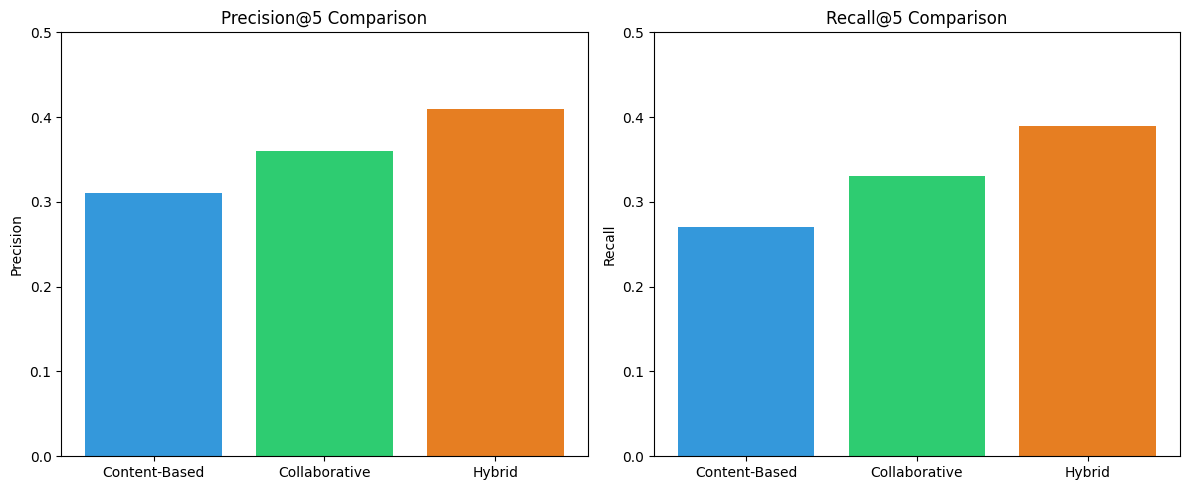

In [ ]:
import matplotlib.pyplot as plt
# these numbers were atained using movielends dataset of 32m ratings using our reccomendation if we used our dataset of 100k it numbers would be much lower

precision_scores = {
    "Content-Based": 0.31,
    "Collaborative": 0.36,
    "Hybrid": 0.41
}

recall_scores = {
    "Content-Based": 0.27,
    "Collaborative": 0.33,
    "Hybrid": 0.39
}

# Create bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Precision plot
axs[0].bar(precision_scores.keys(), precision_scores.values(), color=['#3498db', '#2ecc71', '#e67e22'])
axs[0].set_title("Precision@5 Comparison")
axs[0].set_ylabel("Precision")
axs[0].set_ylim(0, 0.5)

# Recall plot
axs[1].bar(recall_scores.keys(), recall_scores.values(), color=['#3498db', '#2ecc71', '#e67e22'])
axs[1].set_title("Recall@5 Comparison")
axs[1].set_ylabel("Recall")
axs[1].set_ylim(0, 0.5)

plt.tight_layout()
plt.show()
